<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Understanding COVID-19 with Pandas and NetworkX</h1>
<h1>Practical Considerations</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from EpiModel import *

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 792f78317ecef2e33990957fccb9f5b18773bf8c

json      : 2.0.9
pandas    : 1.1.3
networkx  : 2.5
scipy     : 1.6.1
numpy     : 1.19.2
matplotlib: 3.3.2
watermark : 2.1.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## SI Model

The first model we will look at is called the SI model and it only consists of two compartments (susceptible and infectious) and one transion between them

In [4]:
beta = 0.2
SI = EpiModel()
SI.add_interaction('S', 'I', 'I', beta)

print(SI)

Epidemic Model with 2 compartments and 1 transitions:

S + I = I 0.200000



In other words, when a susceptiblem person encounters an infectious person, s/he aquires the infection with probability 0.2. We can integrate it easily. If in our initial population of 100,000 individuals we have 10 who are infected at time zero

In [5]:
N = 100000
I0 = 10

SI.integrate(100, S=N-I0, I=I0)

And to plot it:

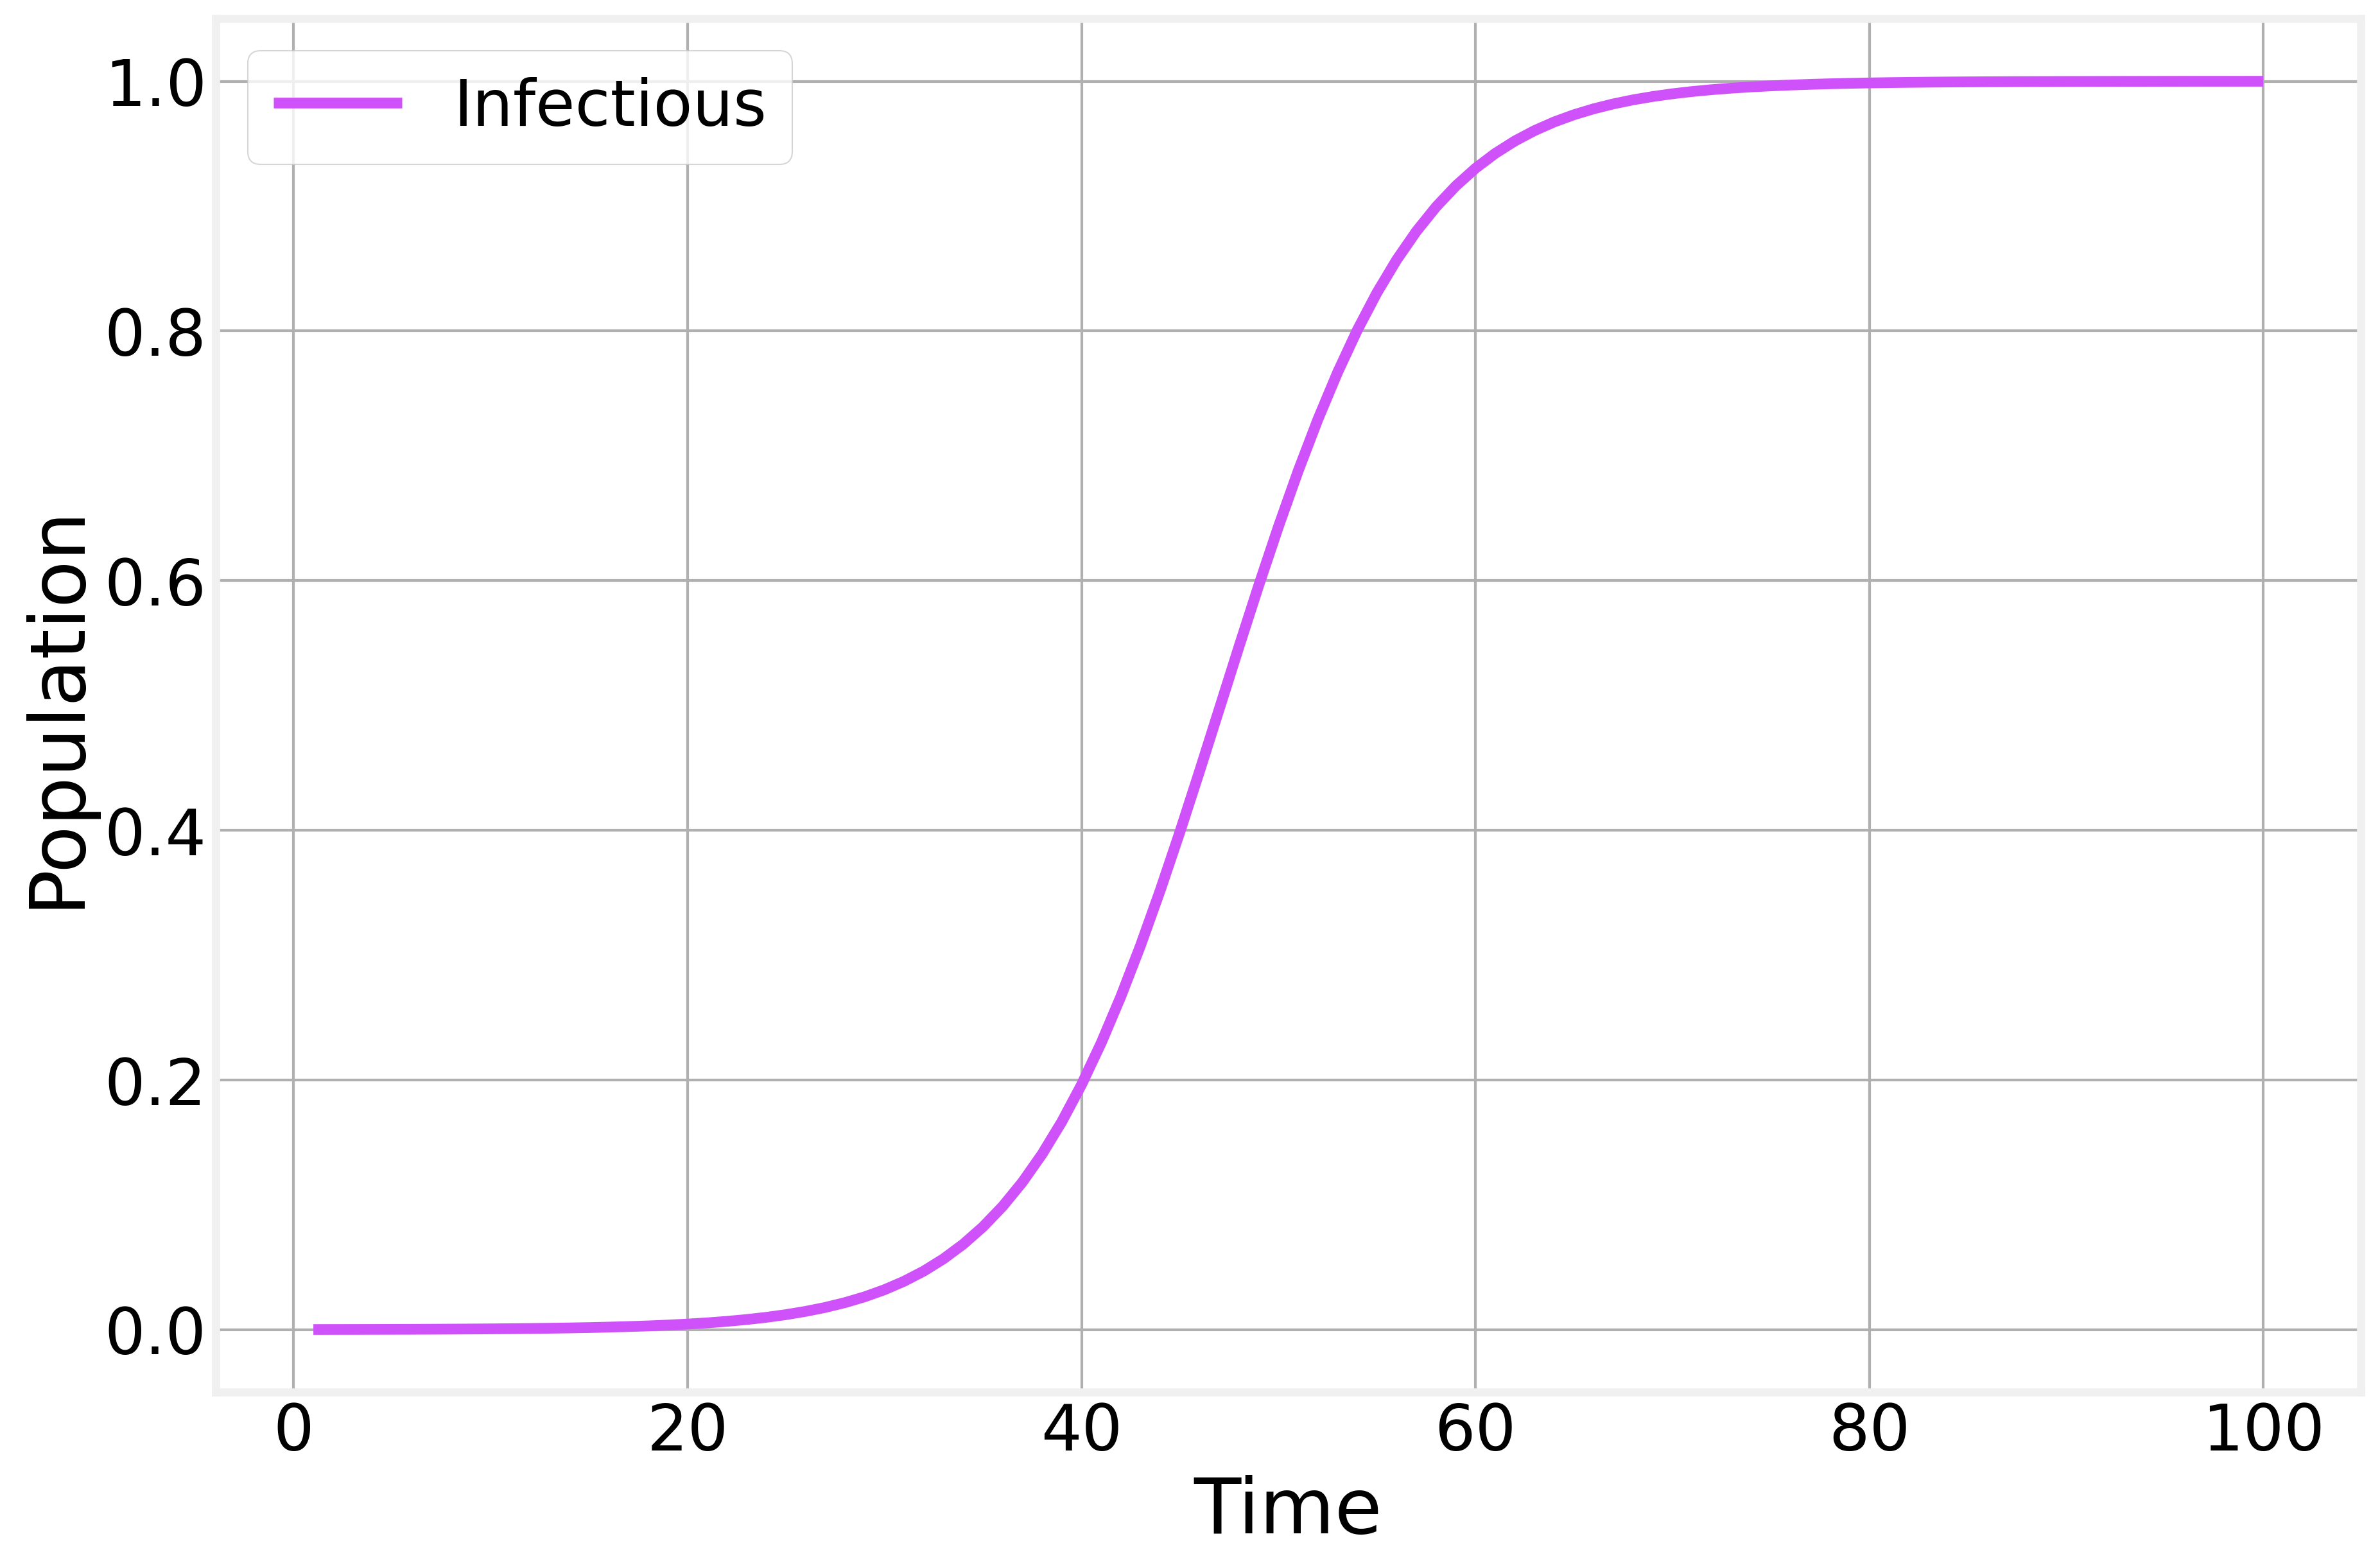

In [6]:
ax = (SI.I/N).plot(label='Infectious', color=colors[1])
ax.set_xlabel('Time')
ax.set_ylabel('Population')
#ax.set_title('SI Model')
ax.legend()

This isn't very interesting: after a few steps everyone is infected!

## SIR Model

A more interesting and realistic model is the SIR model. It allows people to recover from the infection after some time, so now we have 3 compartments and 2 transitions

In [7]:
beta = 0.2
mu = 0.1

SIR = EpiModel()
SIR.add_interaction('S', 'I', 'I', beta)
SIR.add_spontaneous('I', 'R', mu)

In [8]:
print(SIR)

Epidemic Model with 3 compartments and 2 transitions:

S + I = I 0.200000
I -> R 0.100000

R0=2.00


And the dynamics is more interesting as well:

In [9]:
SIR.integrate(365, S=N-I0, I=I0, R=0)

And a quick visualization

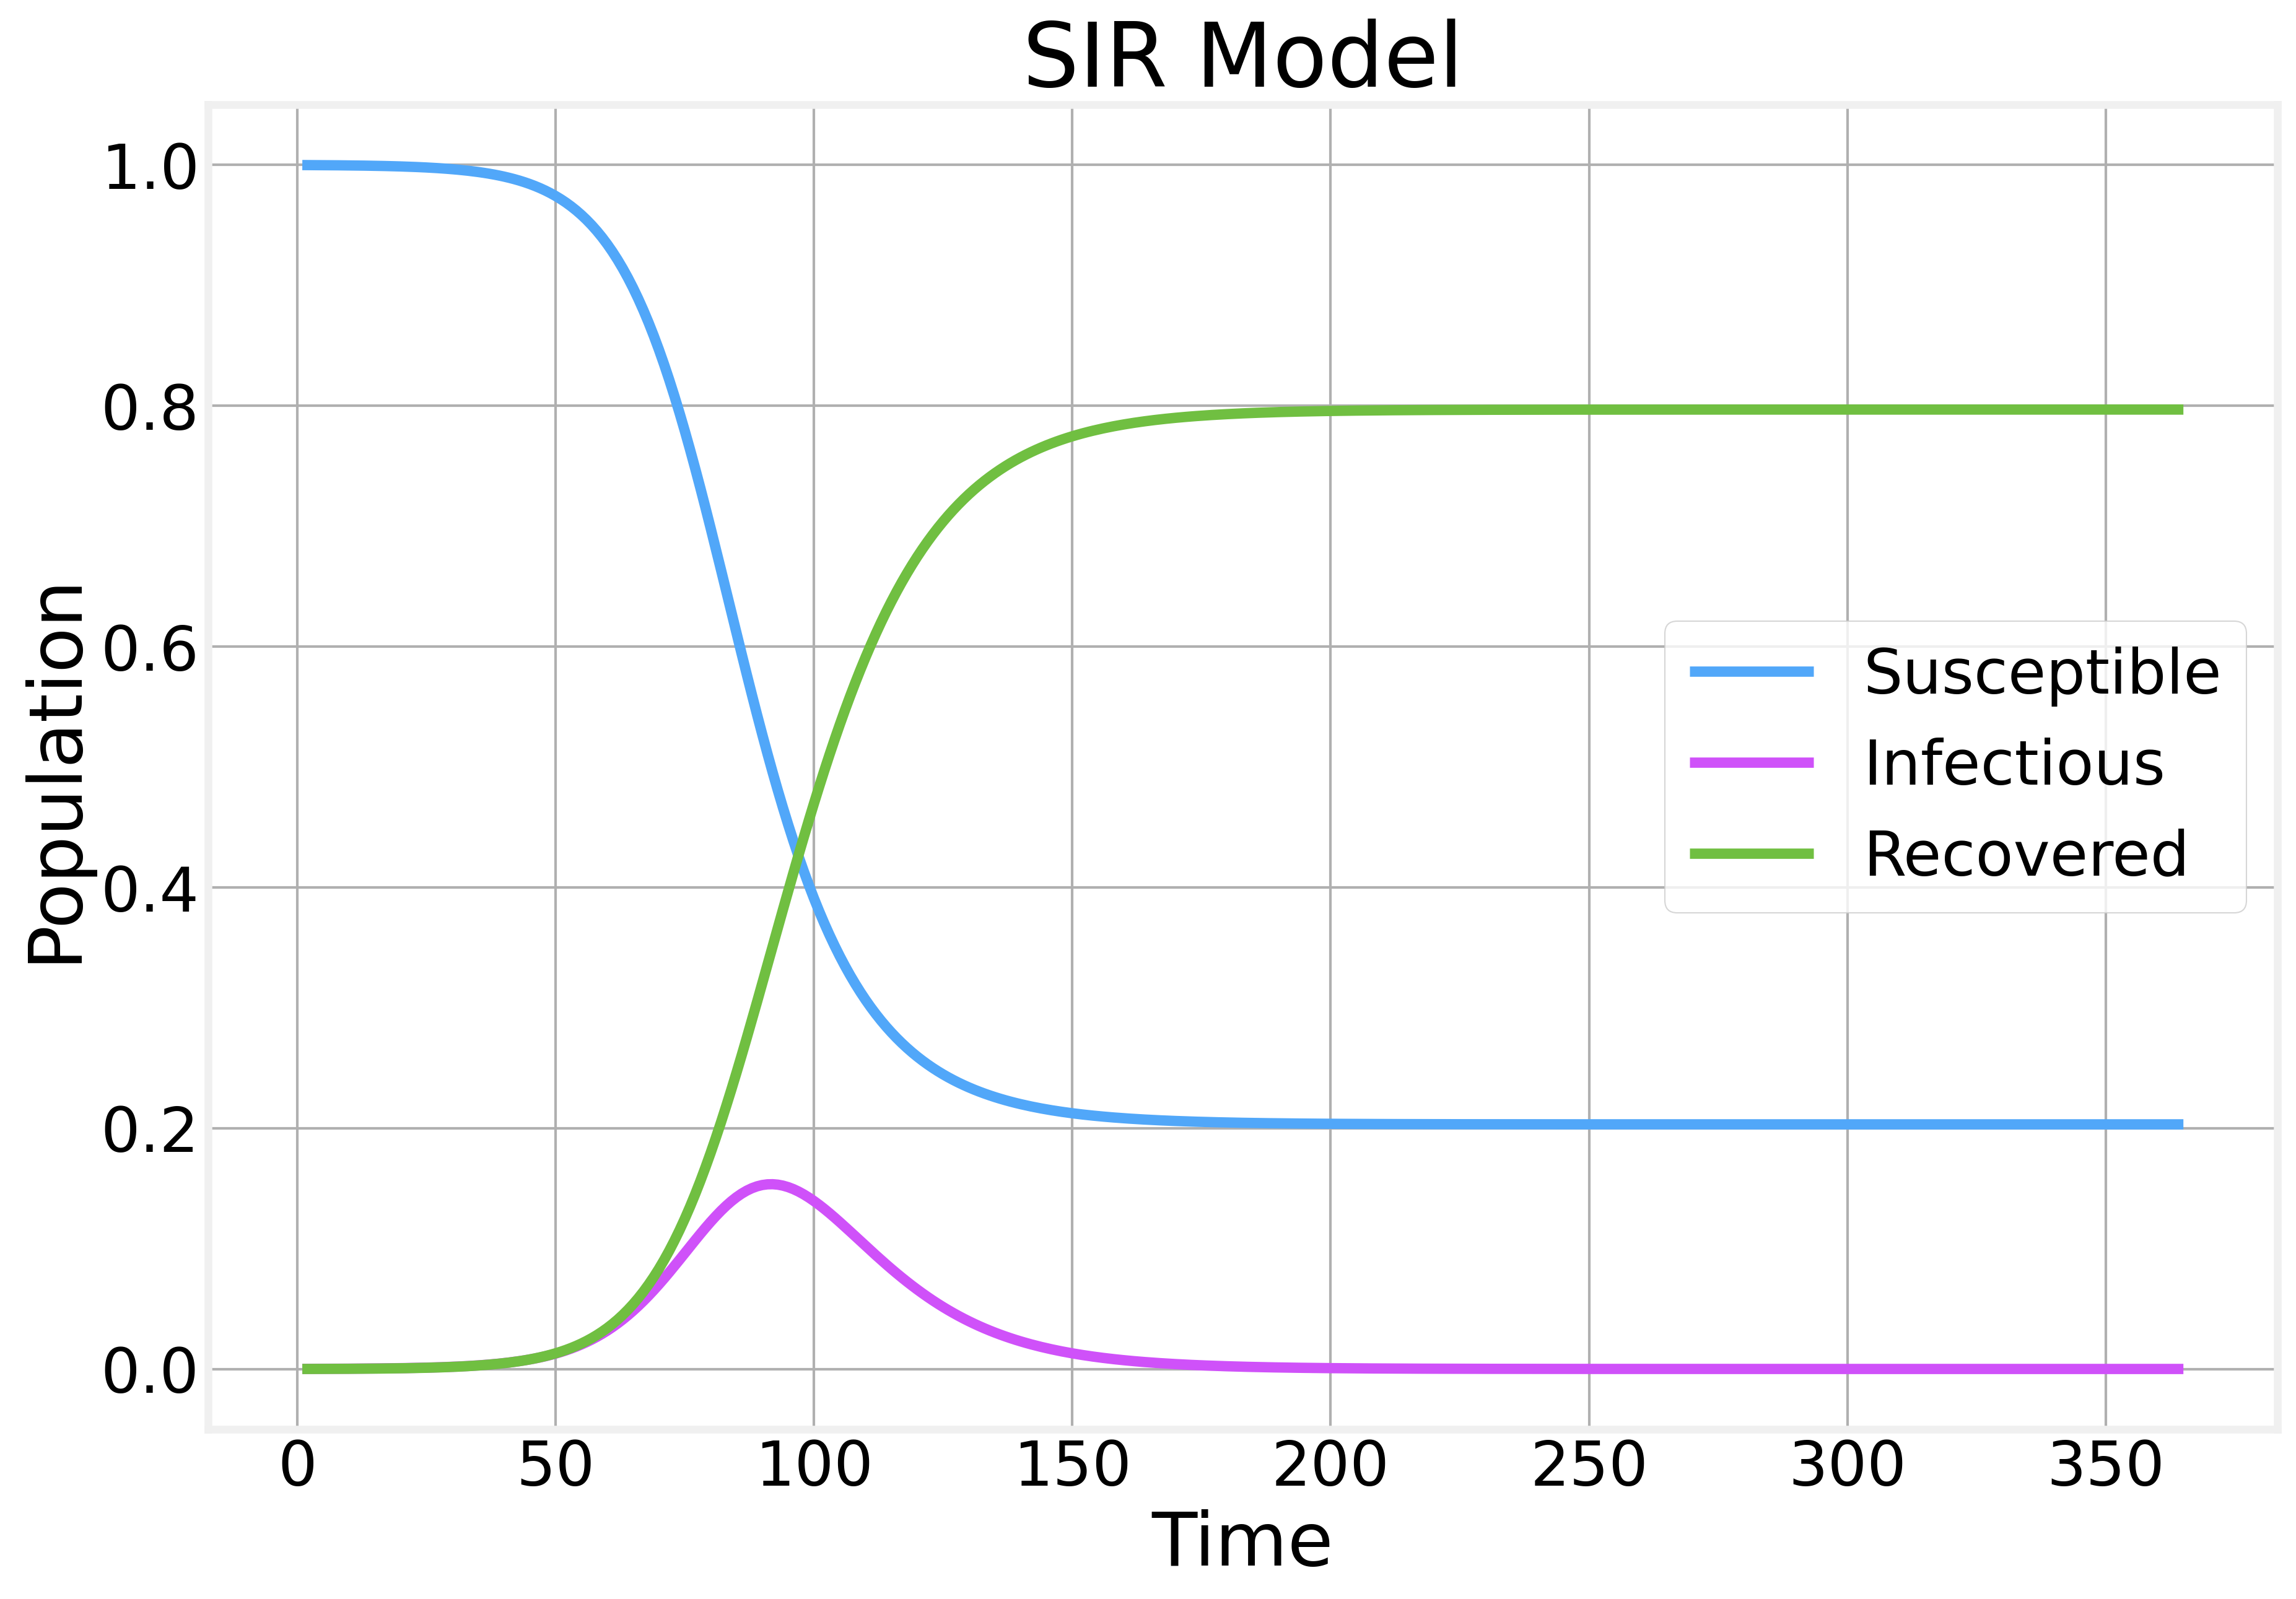

In [10]:
ax = SIR.plot('SIR Model', normed=True)
ax.legend(['Susceptible', 'Infectious', 'Recovered'])

The purple line is the number of currently infectious cases as a function of time. As we can see, not all of the population is infectious at the same time, and, in fact, only about $80\%$ of the population is ever infected, as shown by the green curve representing the fraction of recovered.

The typical bell curve you're likely to see (as asked to flatten) is simply the number of infectious individuals as a function of time:

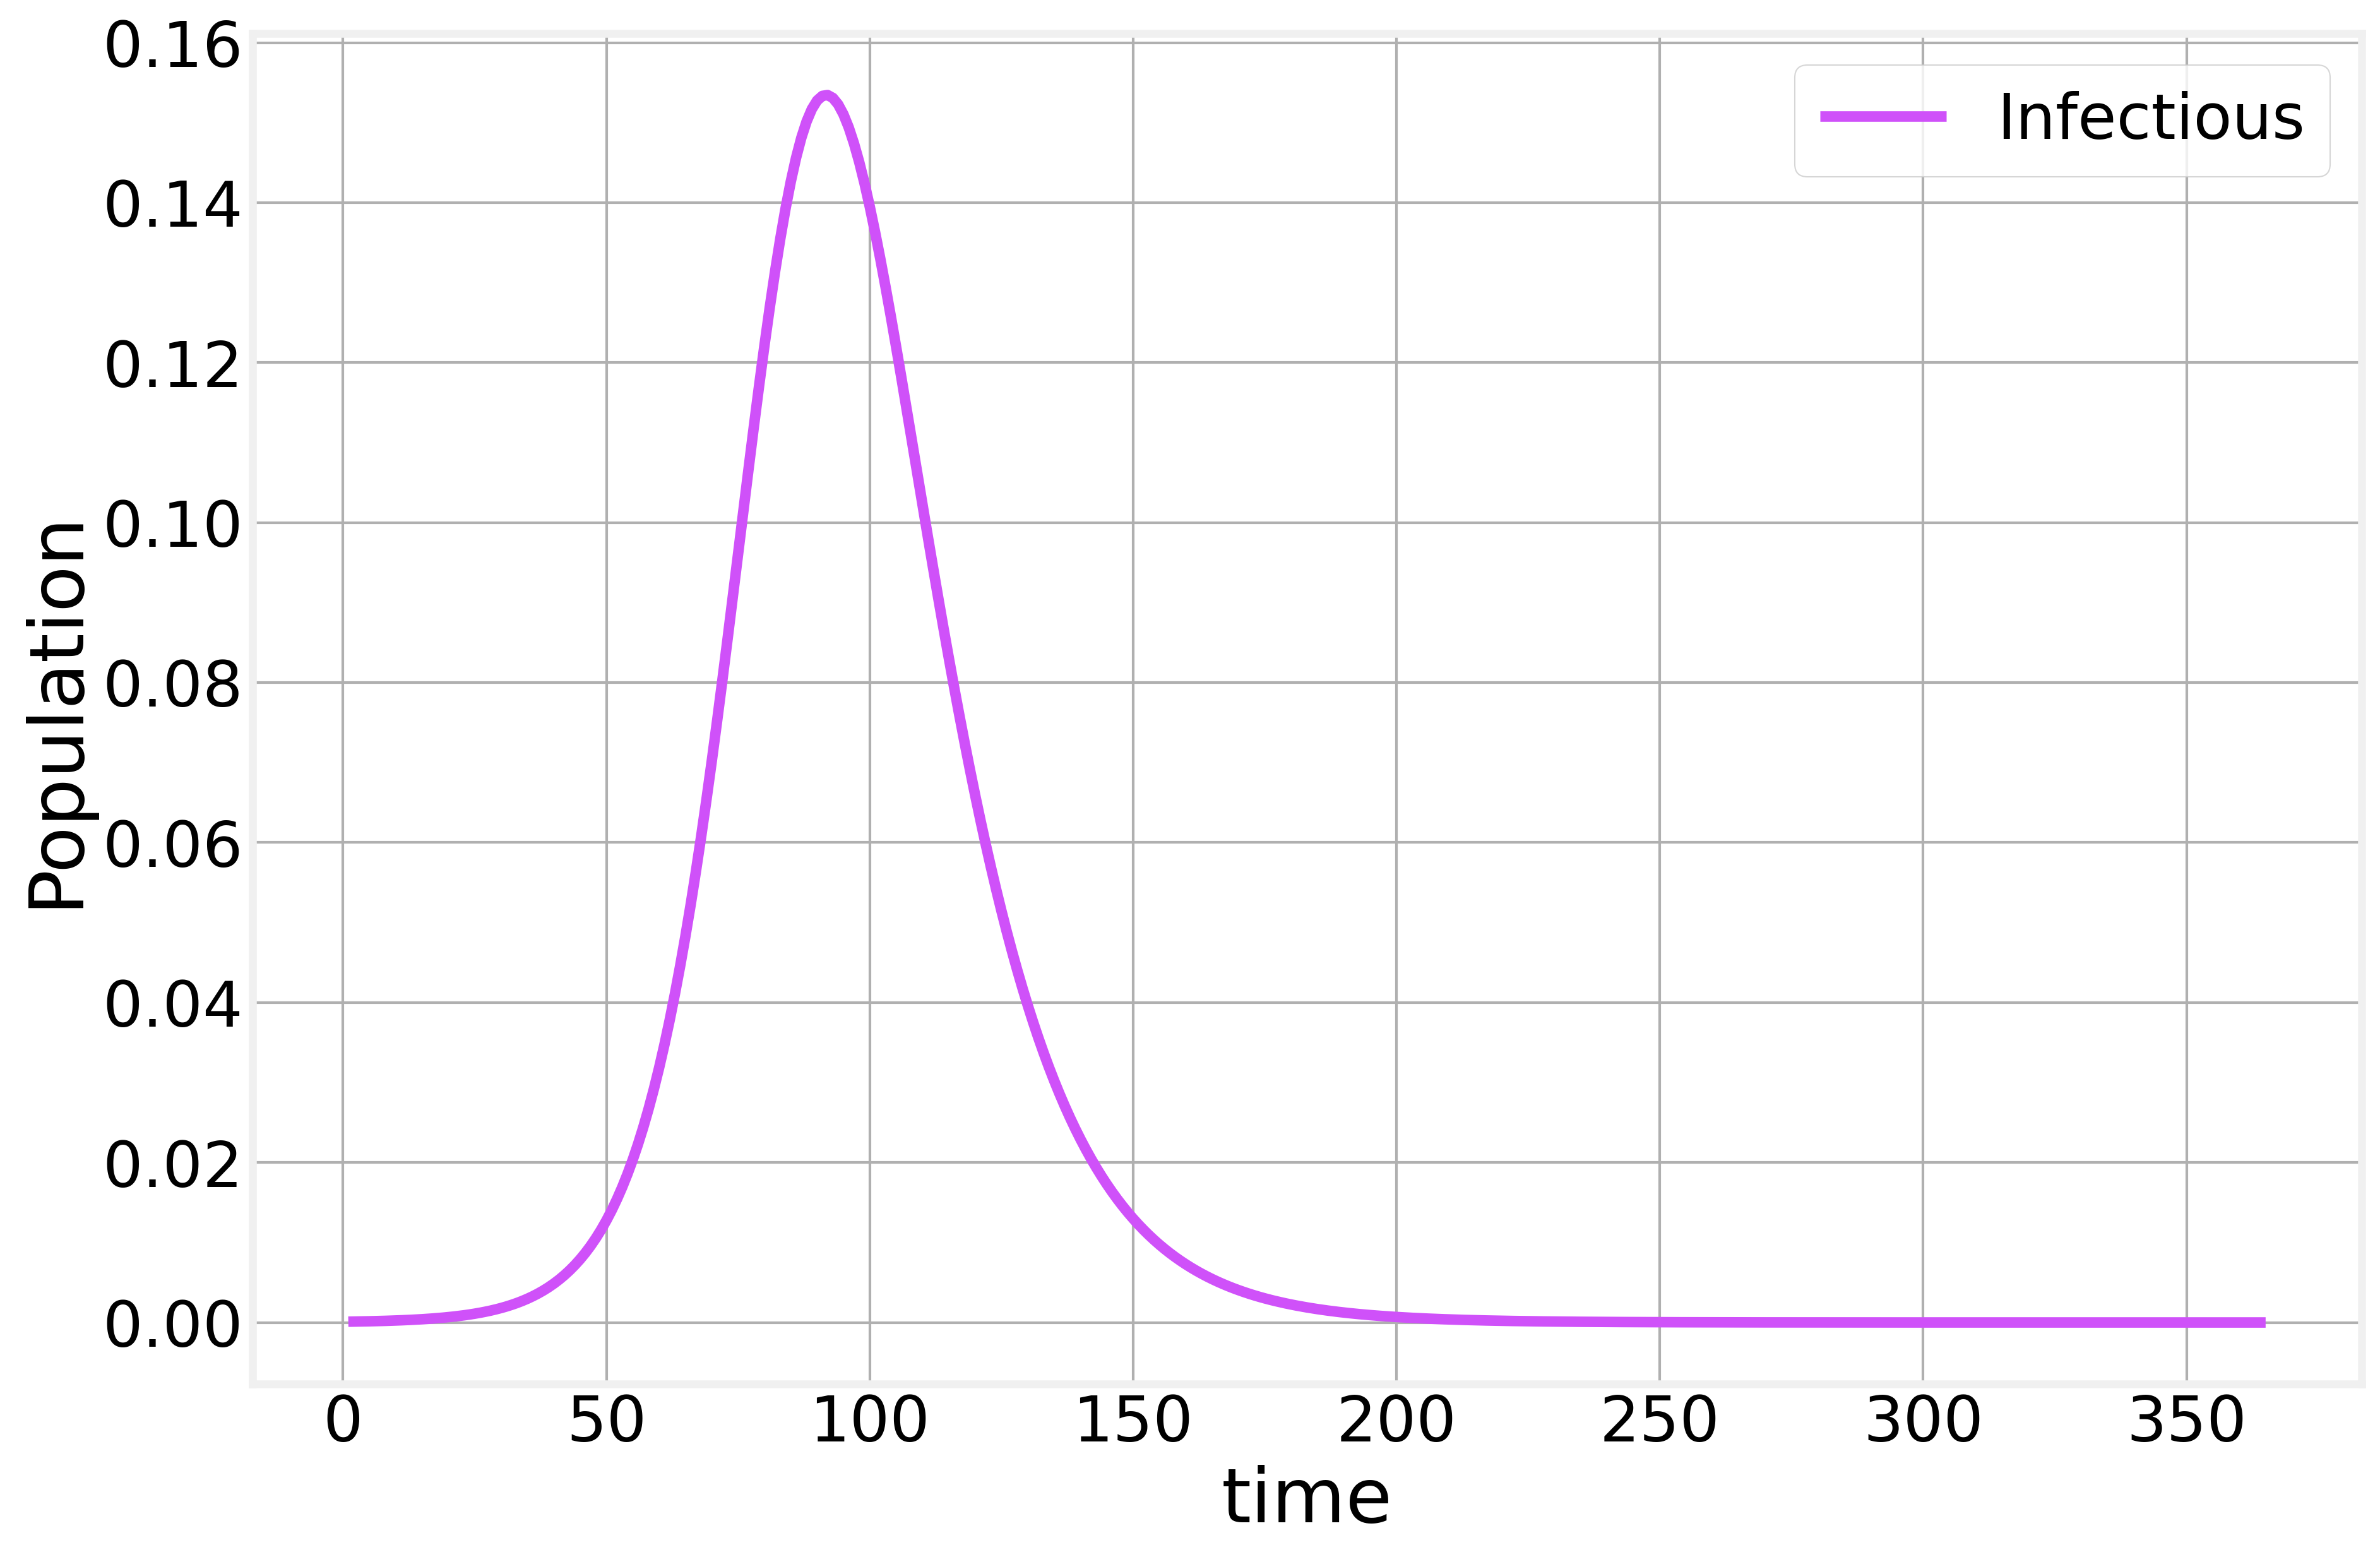

In [11]:
ax=(SIR.I/N).plot(label='Infectious', color=colors[1])
ax.set_xlabel('time')
ax.set_ylabel('Population')
ax.legend()

## Confirmed cases

If you've been paying attention to the news, the numbers of confirmed cases you've been seeing about CoVID19 correspond to, some fraction, $\phi$ of the total number of people that got infected up to that point. We can calculate that easily by simply seeing how many "healthy" people we lost as a function of time:

$$ Confirmed = \phi\left(N-S\right)$$

If, say, $\phi=10\%$ or $\phi=20\%$ of everyone who gets infected takes the test, then:

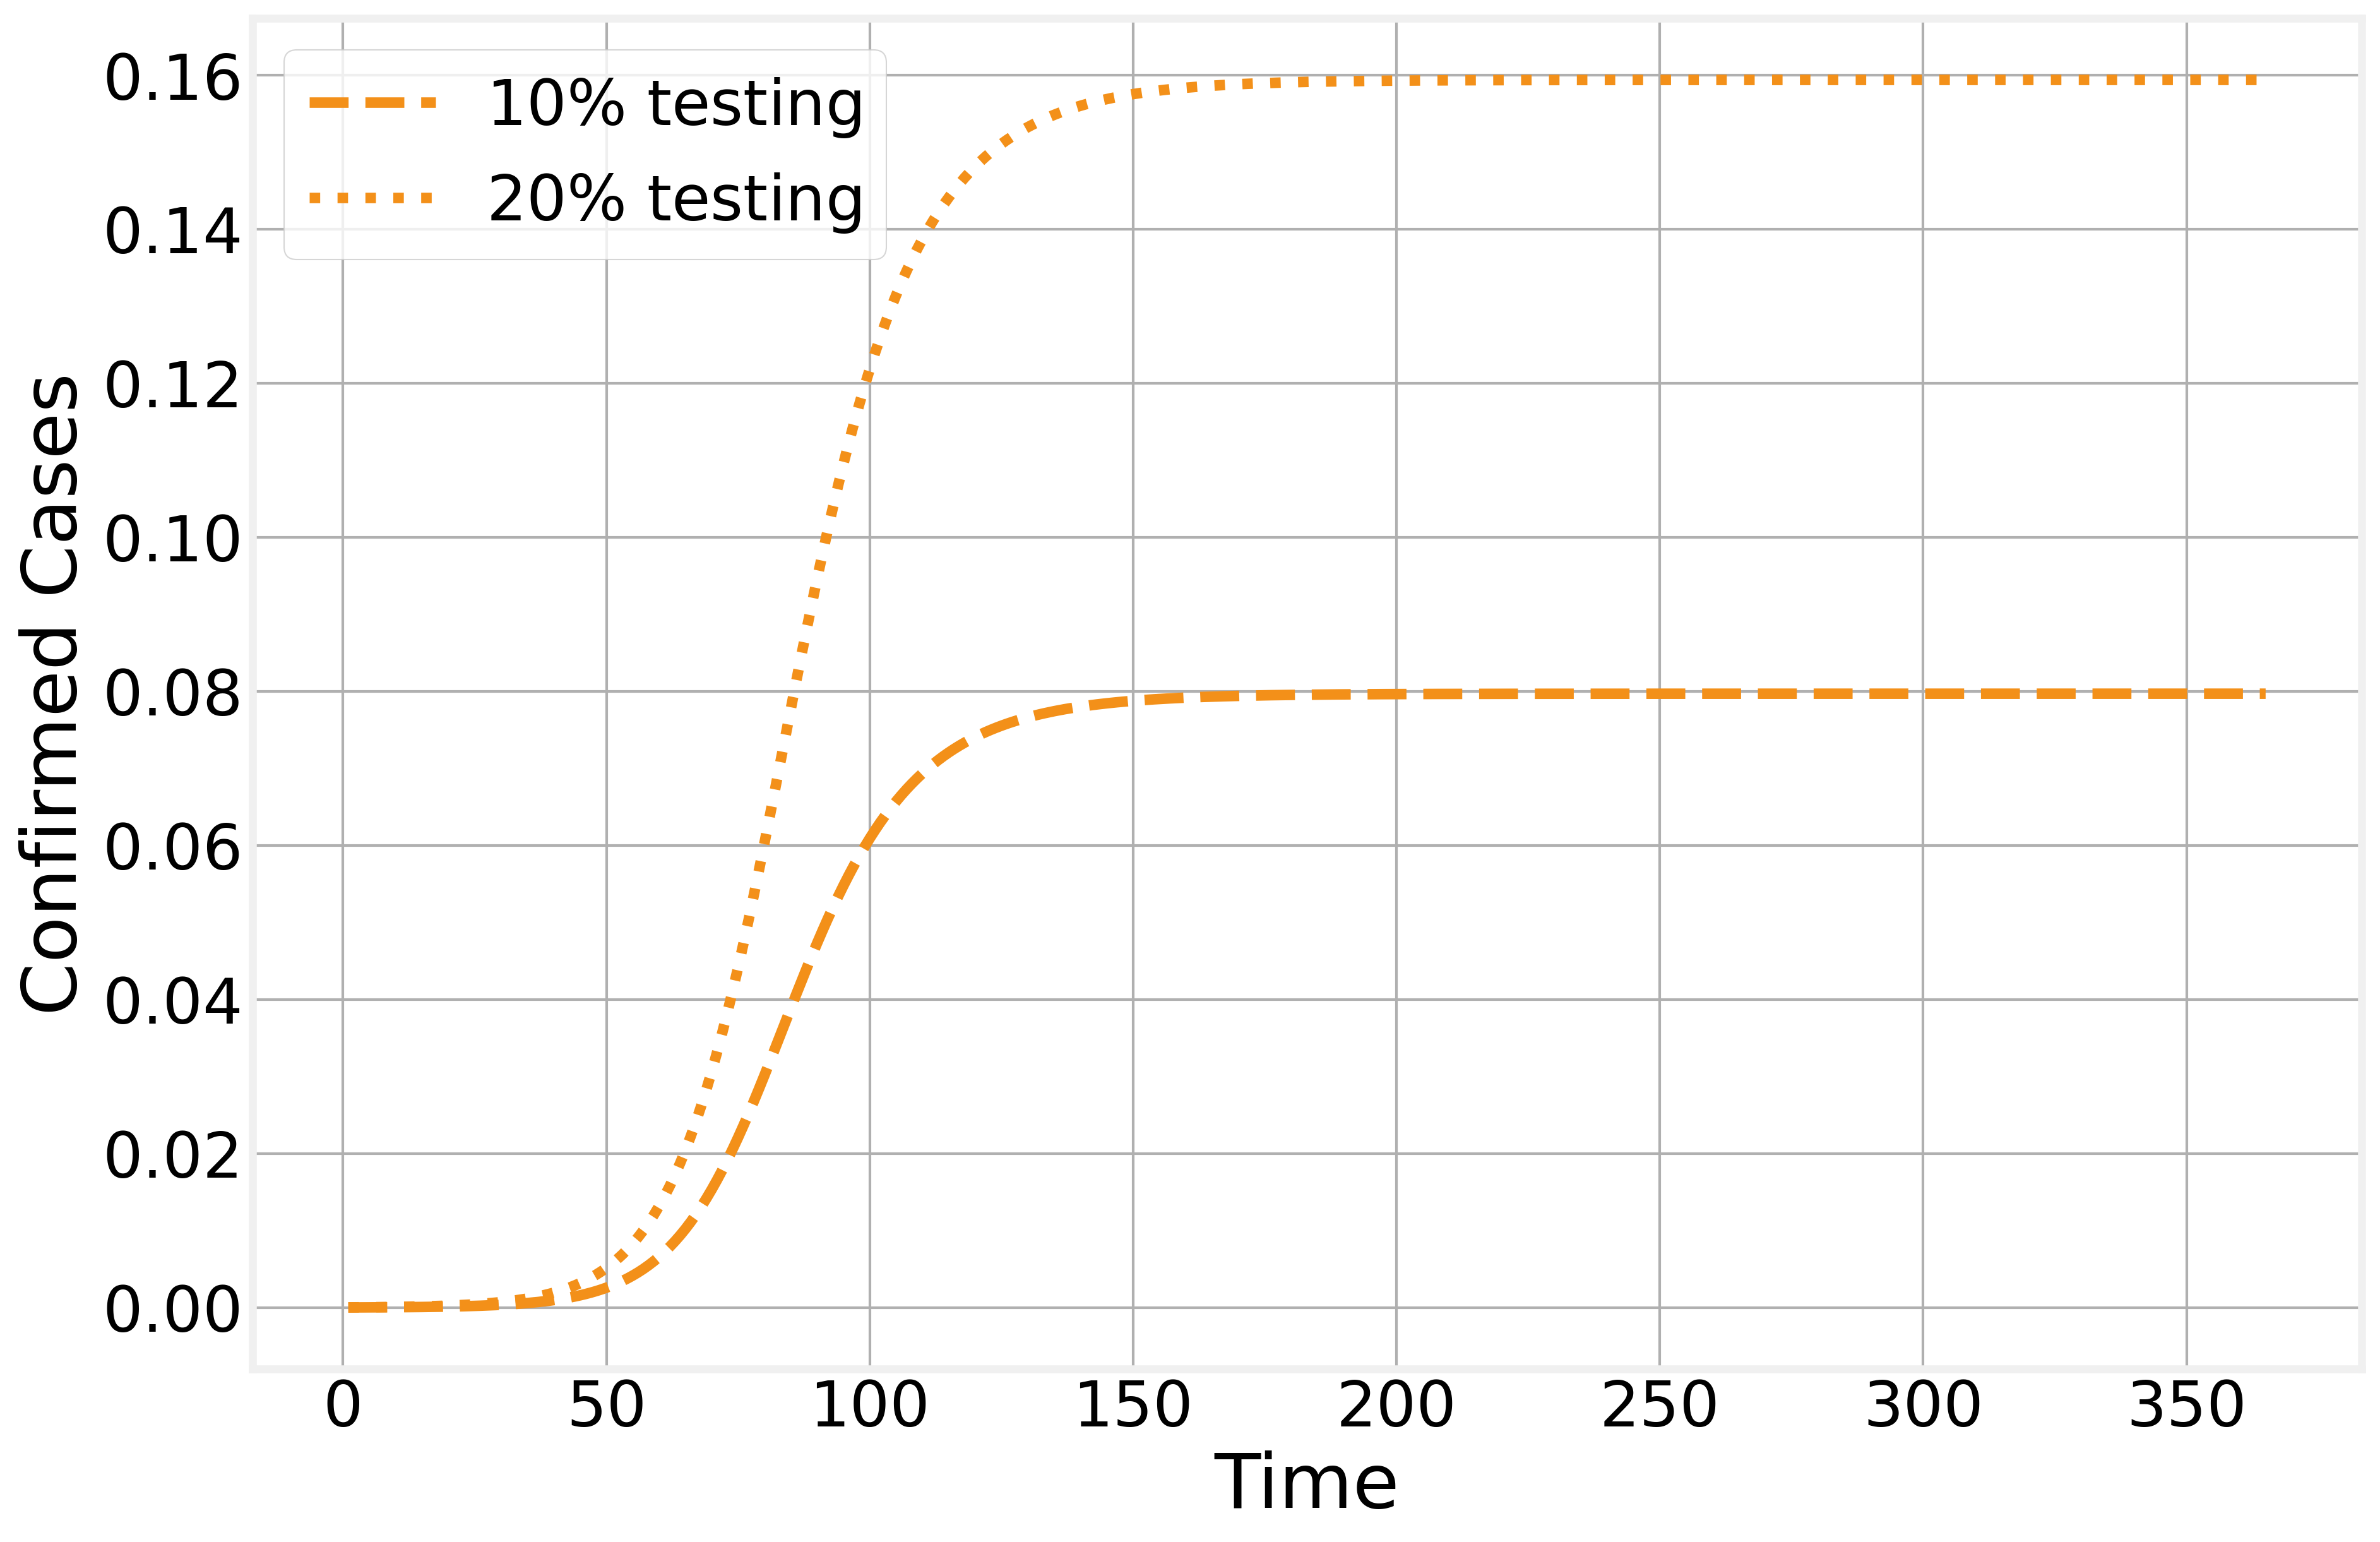

In [12]:
phi = 0.1
ax = ((phi*(N-SIR.S))/N).plot(color=colors[3], linestyle='--', label=r'$10\%$ testing')

phi = 0.2
((phi*(N-SIR.S))/N).plot(ax=ax, color=colors[3], linestyle=':', label=r'$20\%$ testing')


ax.set_xlabel('Time')
ax.set_ylabel('Confirmed Cases')
ax.legend()

Naturaly, the higher the testing percentage, the higher the number of confirmed cases. Please note that here we are ignoring the number of healthy individuals that take the test and it comes back negative as we are only interested in the number of confirmed cases.

And the number of recovered cases follows a similar path, with a few days lag. Here we apply the same factor of $\phi$ to the number of recovered, since in principle, those would be the only ones we could observe recovering.

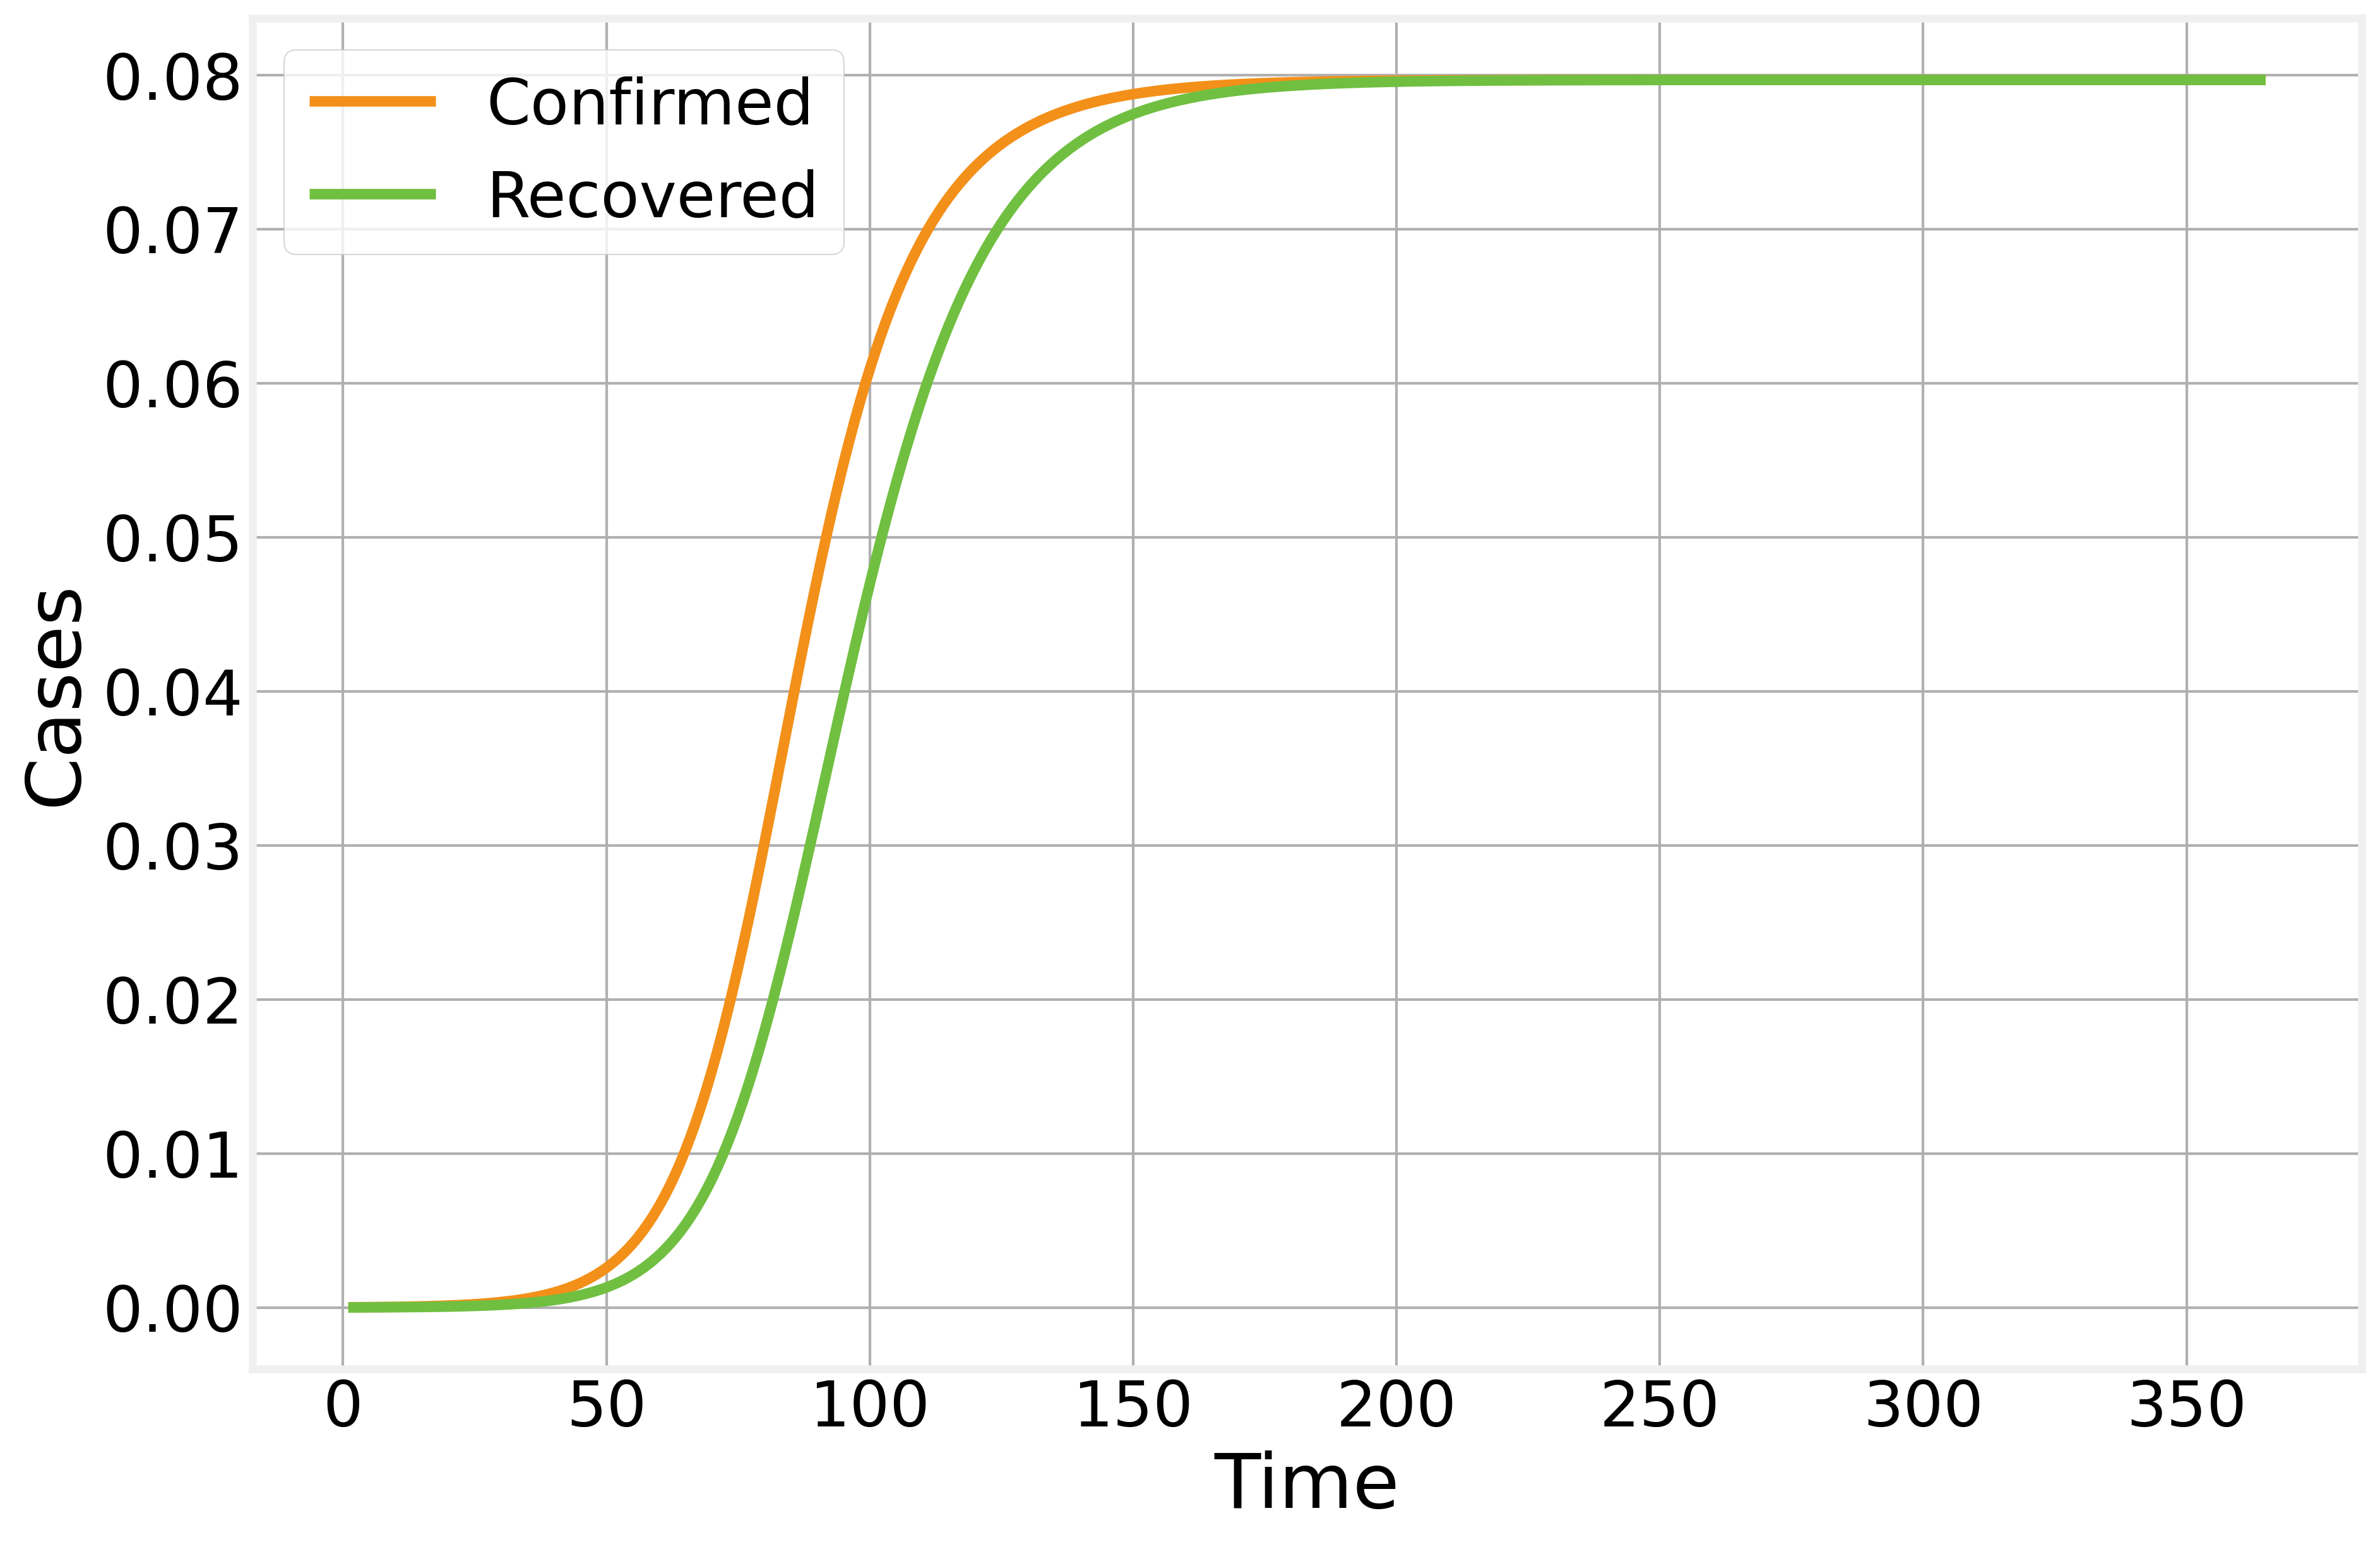

In [13]:
phi = 0.1
ax = ((phi*(N-SIR.S))/N).plot(label='Confirmed', color=colors[3])
((phi*SIR.R)/N).plot(ax=ax, label='Recovered', color=colors[2])
ax.set_xlabel('Time')
ax.set_ylabel('Cases')
ax.legend()

For the sake of clarity I'm making the simplifying assumption that test are instantanous and happen as soon as the infection happens. This is __slightly__ unrealistic :) 

And indeed the numbers do start off growing exponentially as can be easily seen by plotting them on a log-linear scale.

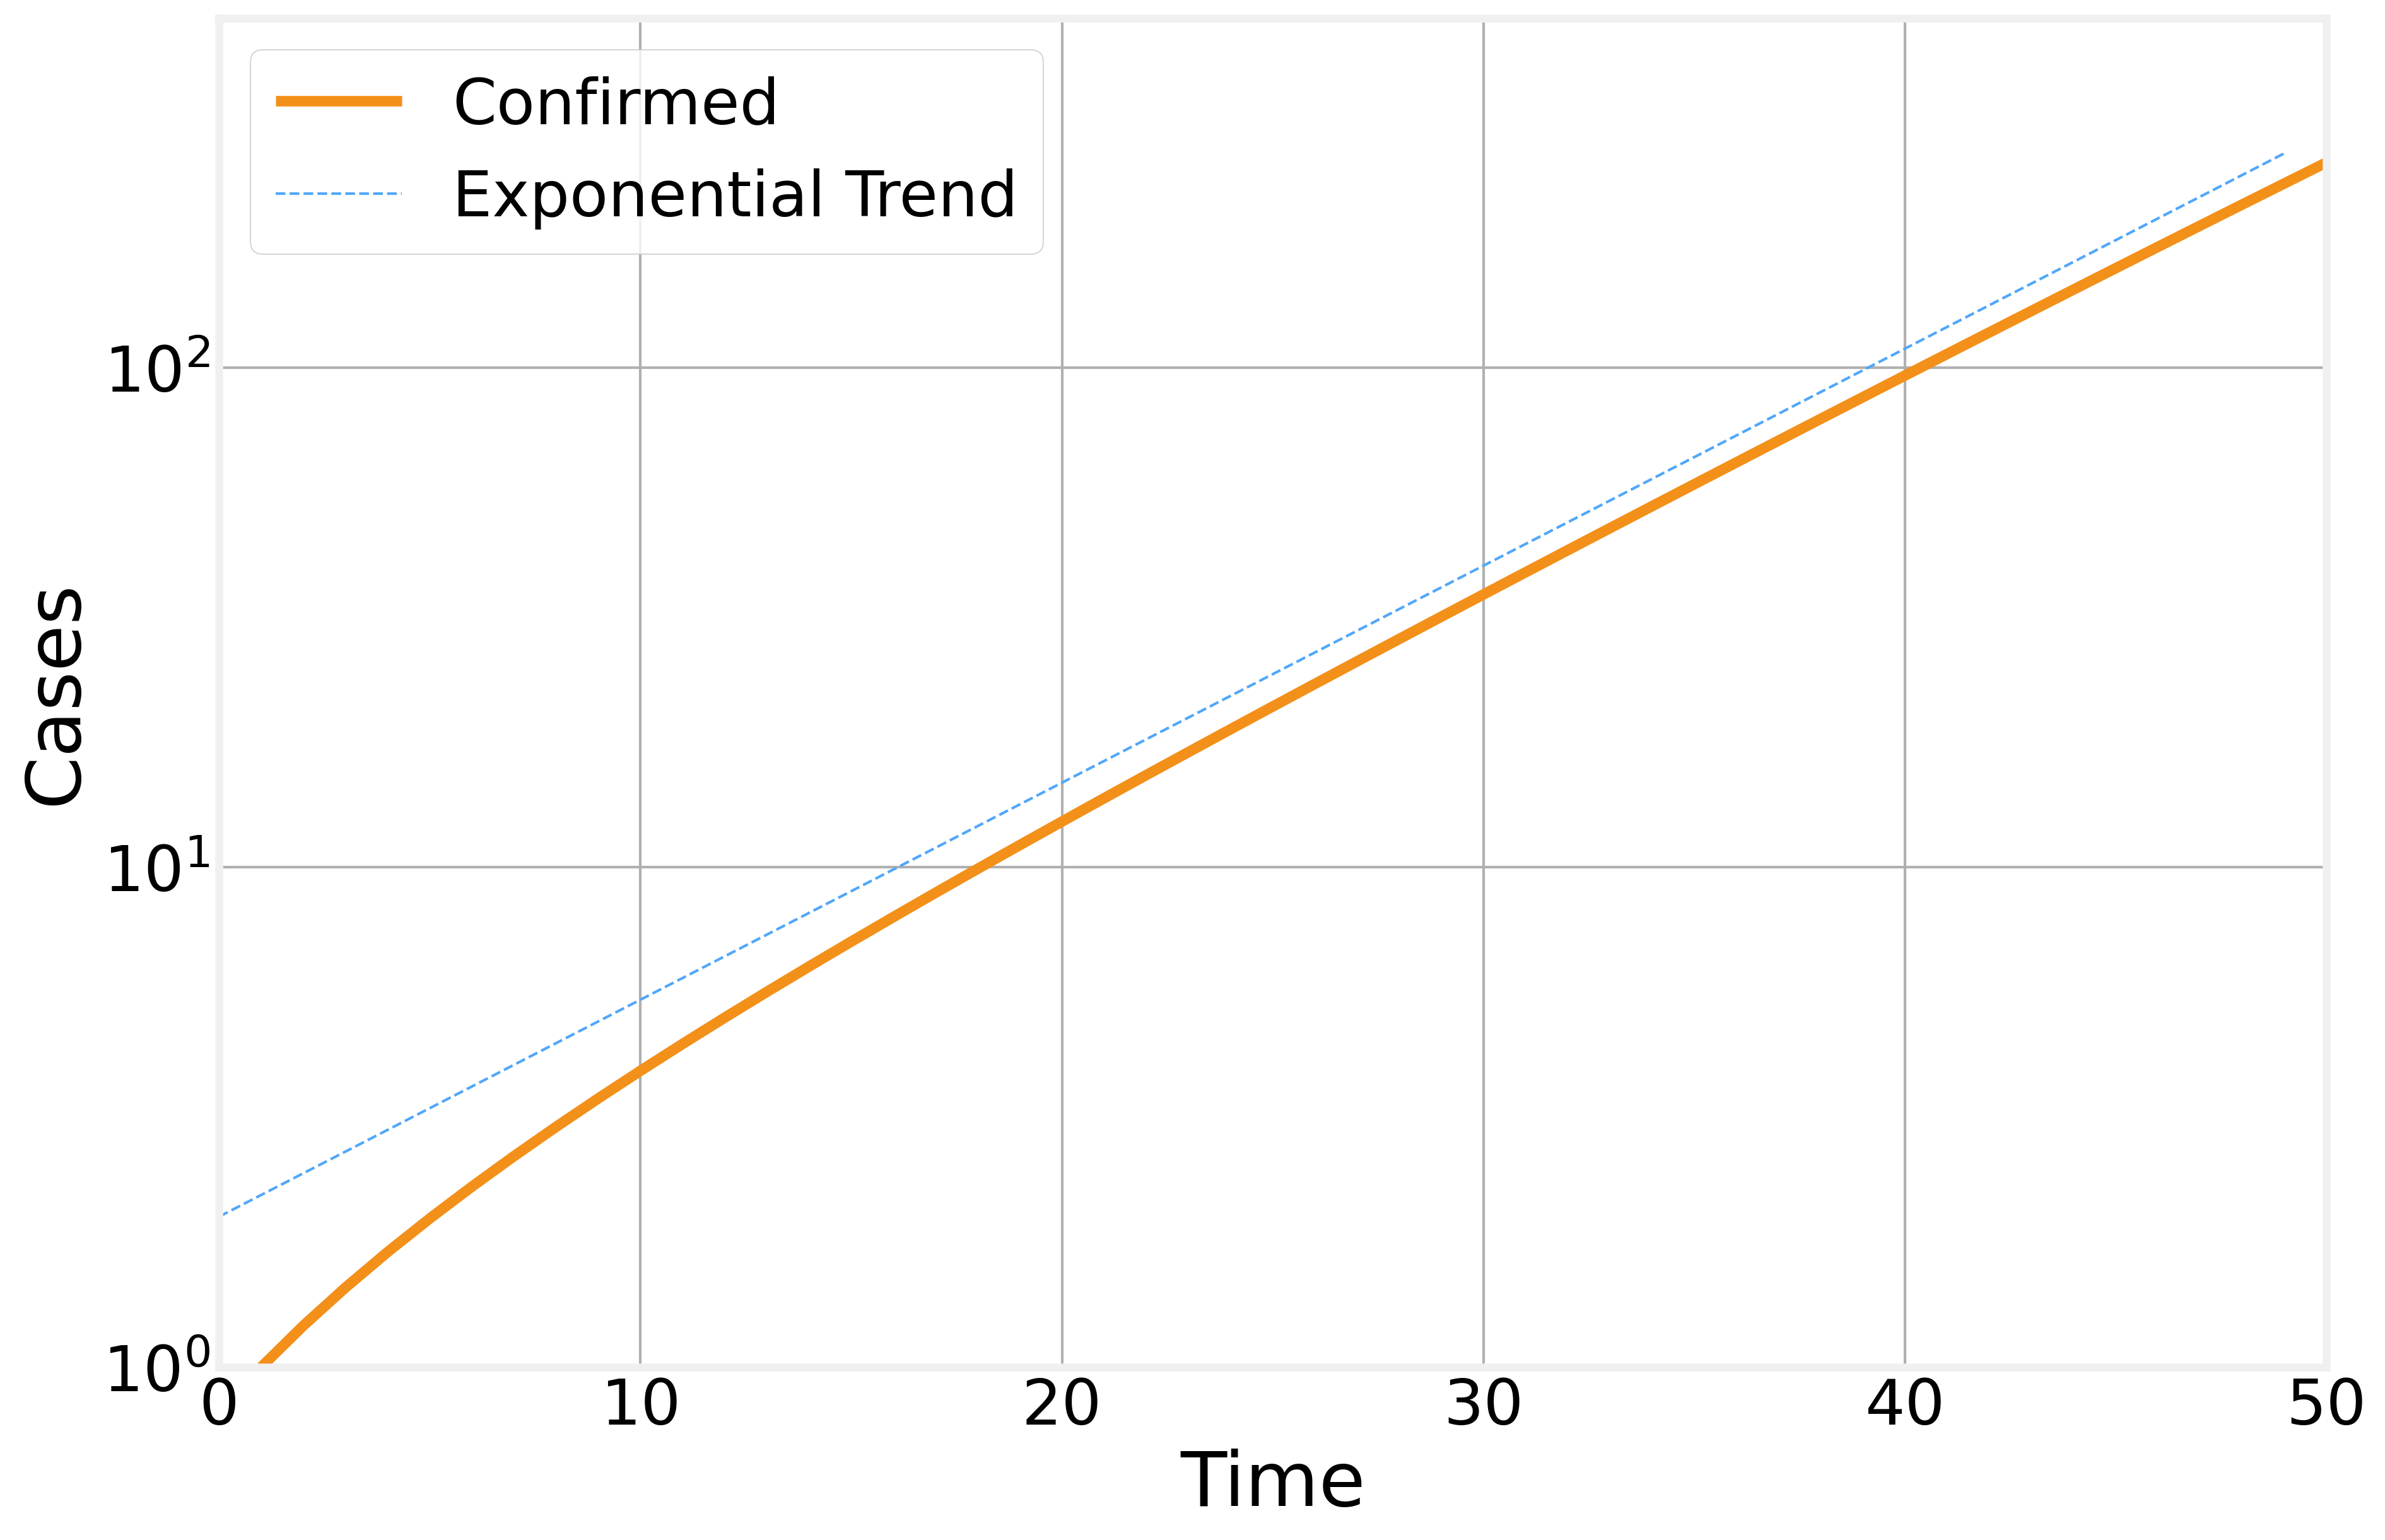

In [14]:
phi = 0.1
ax = (phi*(N-SIR.S[:50])).plot(color=colors[3], label='Confirmed')
t = np.arange(0, 50, 1)
y = 2*np.exp((beta-mu)*t)
ax.plot(t, y, lw=1, linestyle='--', label='Exponential Trend')

ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Cases')
ax.set_xlim(0, 50)
ax.set_ylim(1, 500)
ax.legend()

And we easily calculate the doubling time

In [15]:
doubling_time = np.log(2)/(beta-mu)
print("Doubling time: %u days" % np.round(doubling_time))

Doubling time: 7 days


## Non-uniform testing

Now let's look at a more realistic case. What if, instead of testing exactly $\phi=10\%$ of the cases, starting imediatly, it takes us a while to ramp up testing? Say, we start at 0 for the first week and smootly ramp up over the course of three weeks to a steady state rate of $\phi$?

In [16]:
phi_t = np.ones(365)*0.1 # The steady state rate
phi_t[:7] = 0 # 0 for the first 7 days
phi_t[7:28] = np.linspace(0, 0.1, 21) # ramp up over 3 weeks

Now our curves looks a bit more interesting.

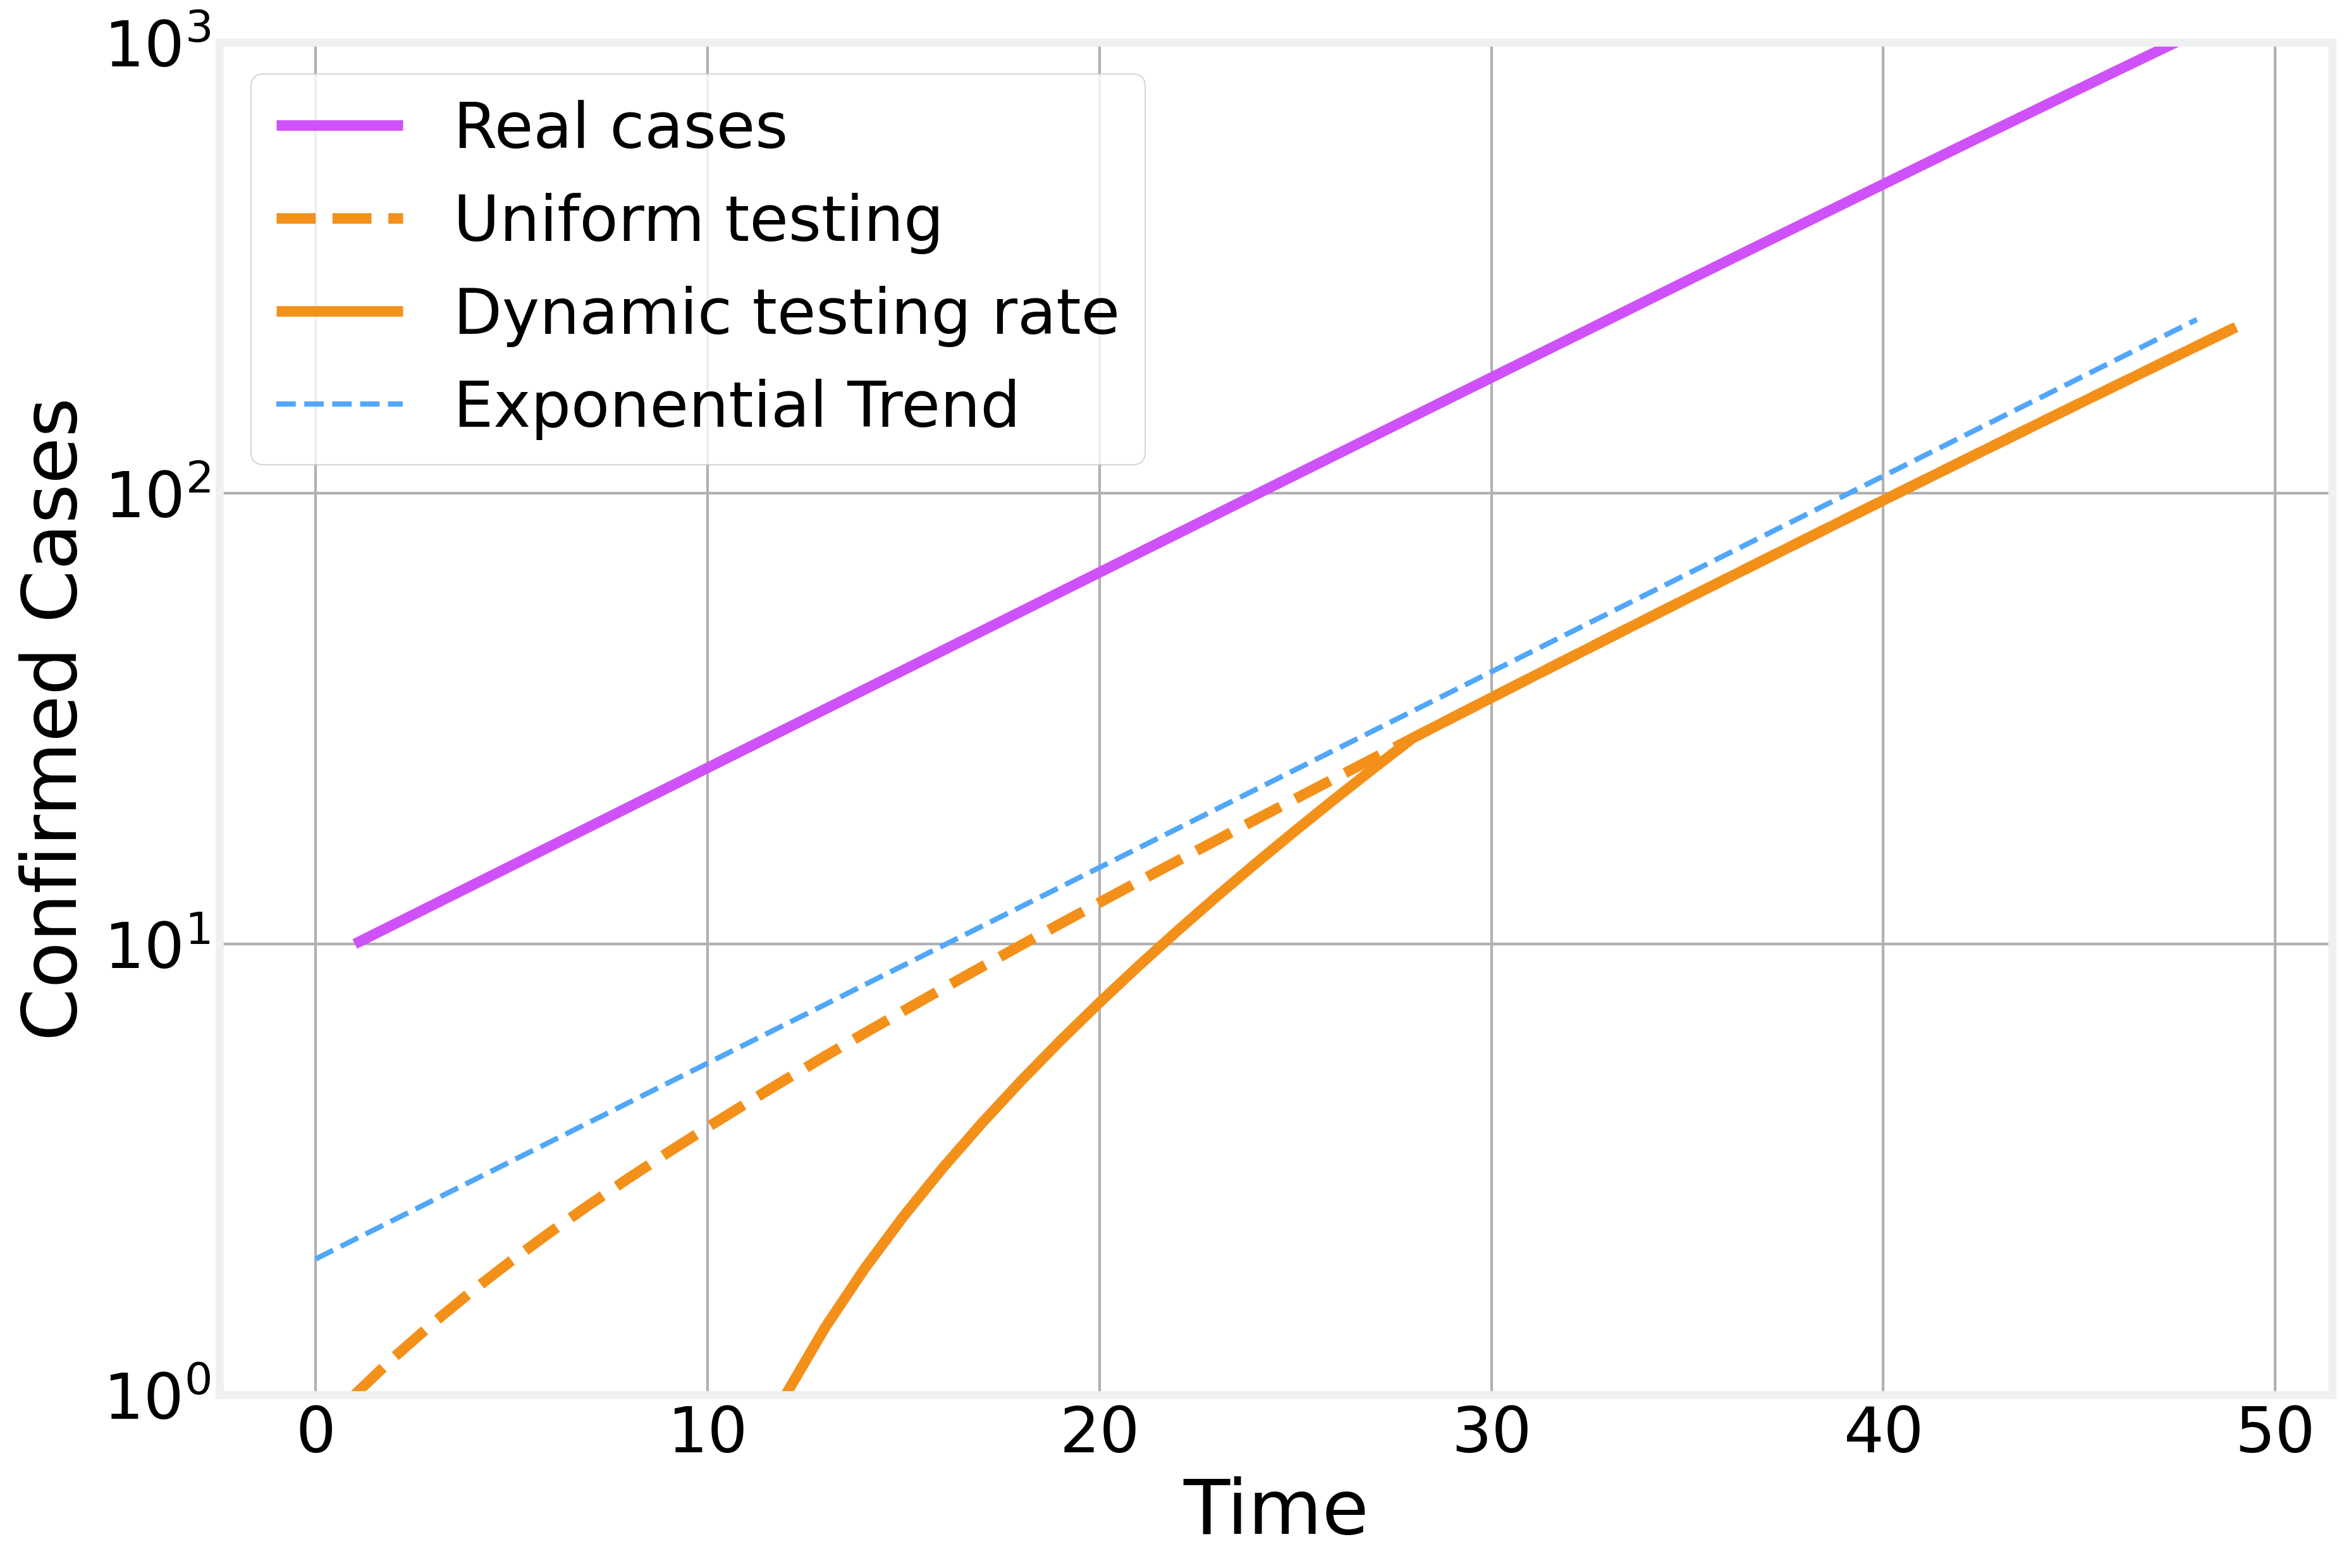

In [17]:
ax = SIR.I.iloc[:49].plot(label='Real cases', color=colors[1])
(phi*(N-SIR.S)).iloc[:49].plot(ax=ax, label='Uniform testing', color=colors[3], linestyle='--')
(phi_t*(N-SIR.S)).iloc[:49].plot(ax=ax, label='Dynamic testing rate', color=colors[3])

t = np.arange(0, 49, 1)
y = 2*np.exp((beta-mu)*t)
ax.plot(t, y, lw=2, linestyle='--', label='Exponential Trend')
ax.set_ylim(1, 1000)
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Confirmed Cases')
ax.set_yscale('log')

Two things should be noted here:

- By the time we detect the first case, on day 11, the real number of cases is already several dozen
- The increase in testing rate gets muddled together with the increase in the number of cases to look like a much faster increase

Naturally, the opposite is also true, if we decrease the number of tests, we see an artificial slowing down of the number of cases

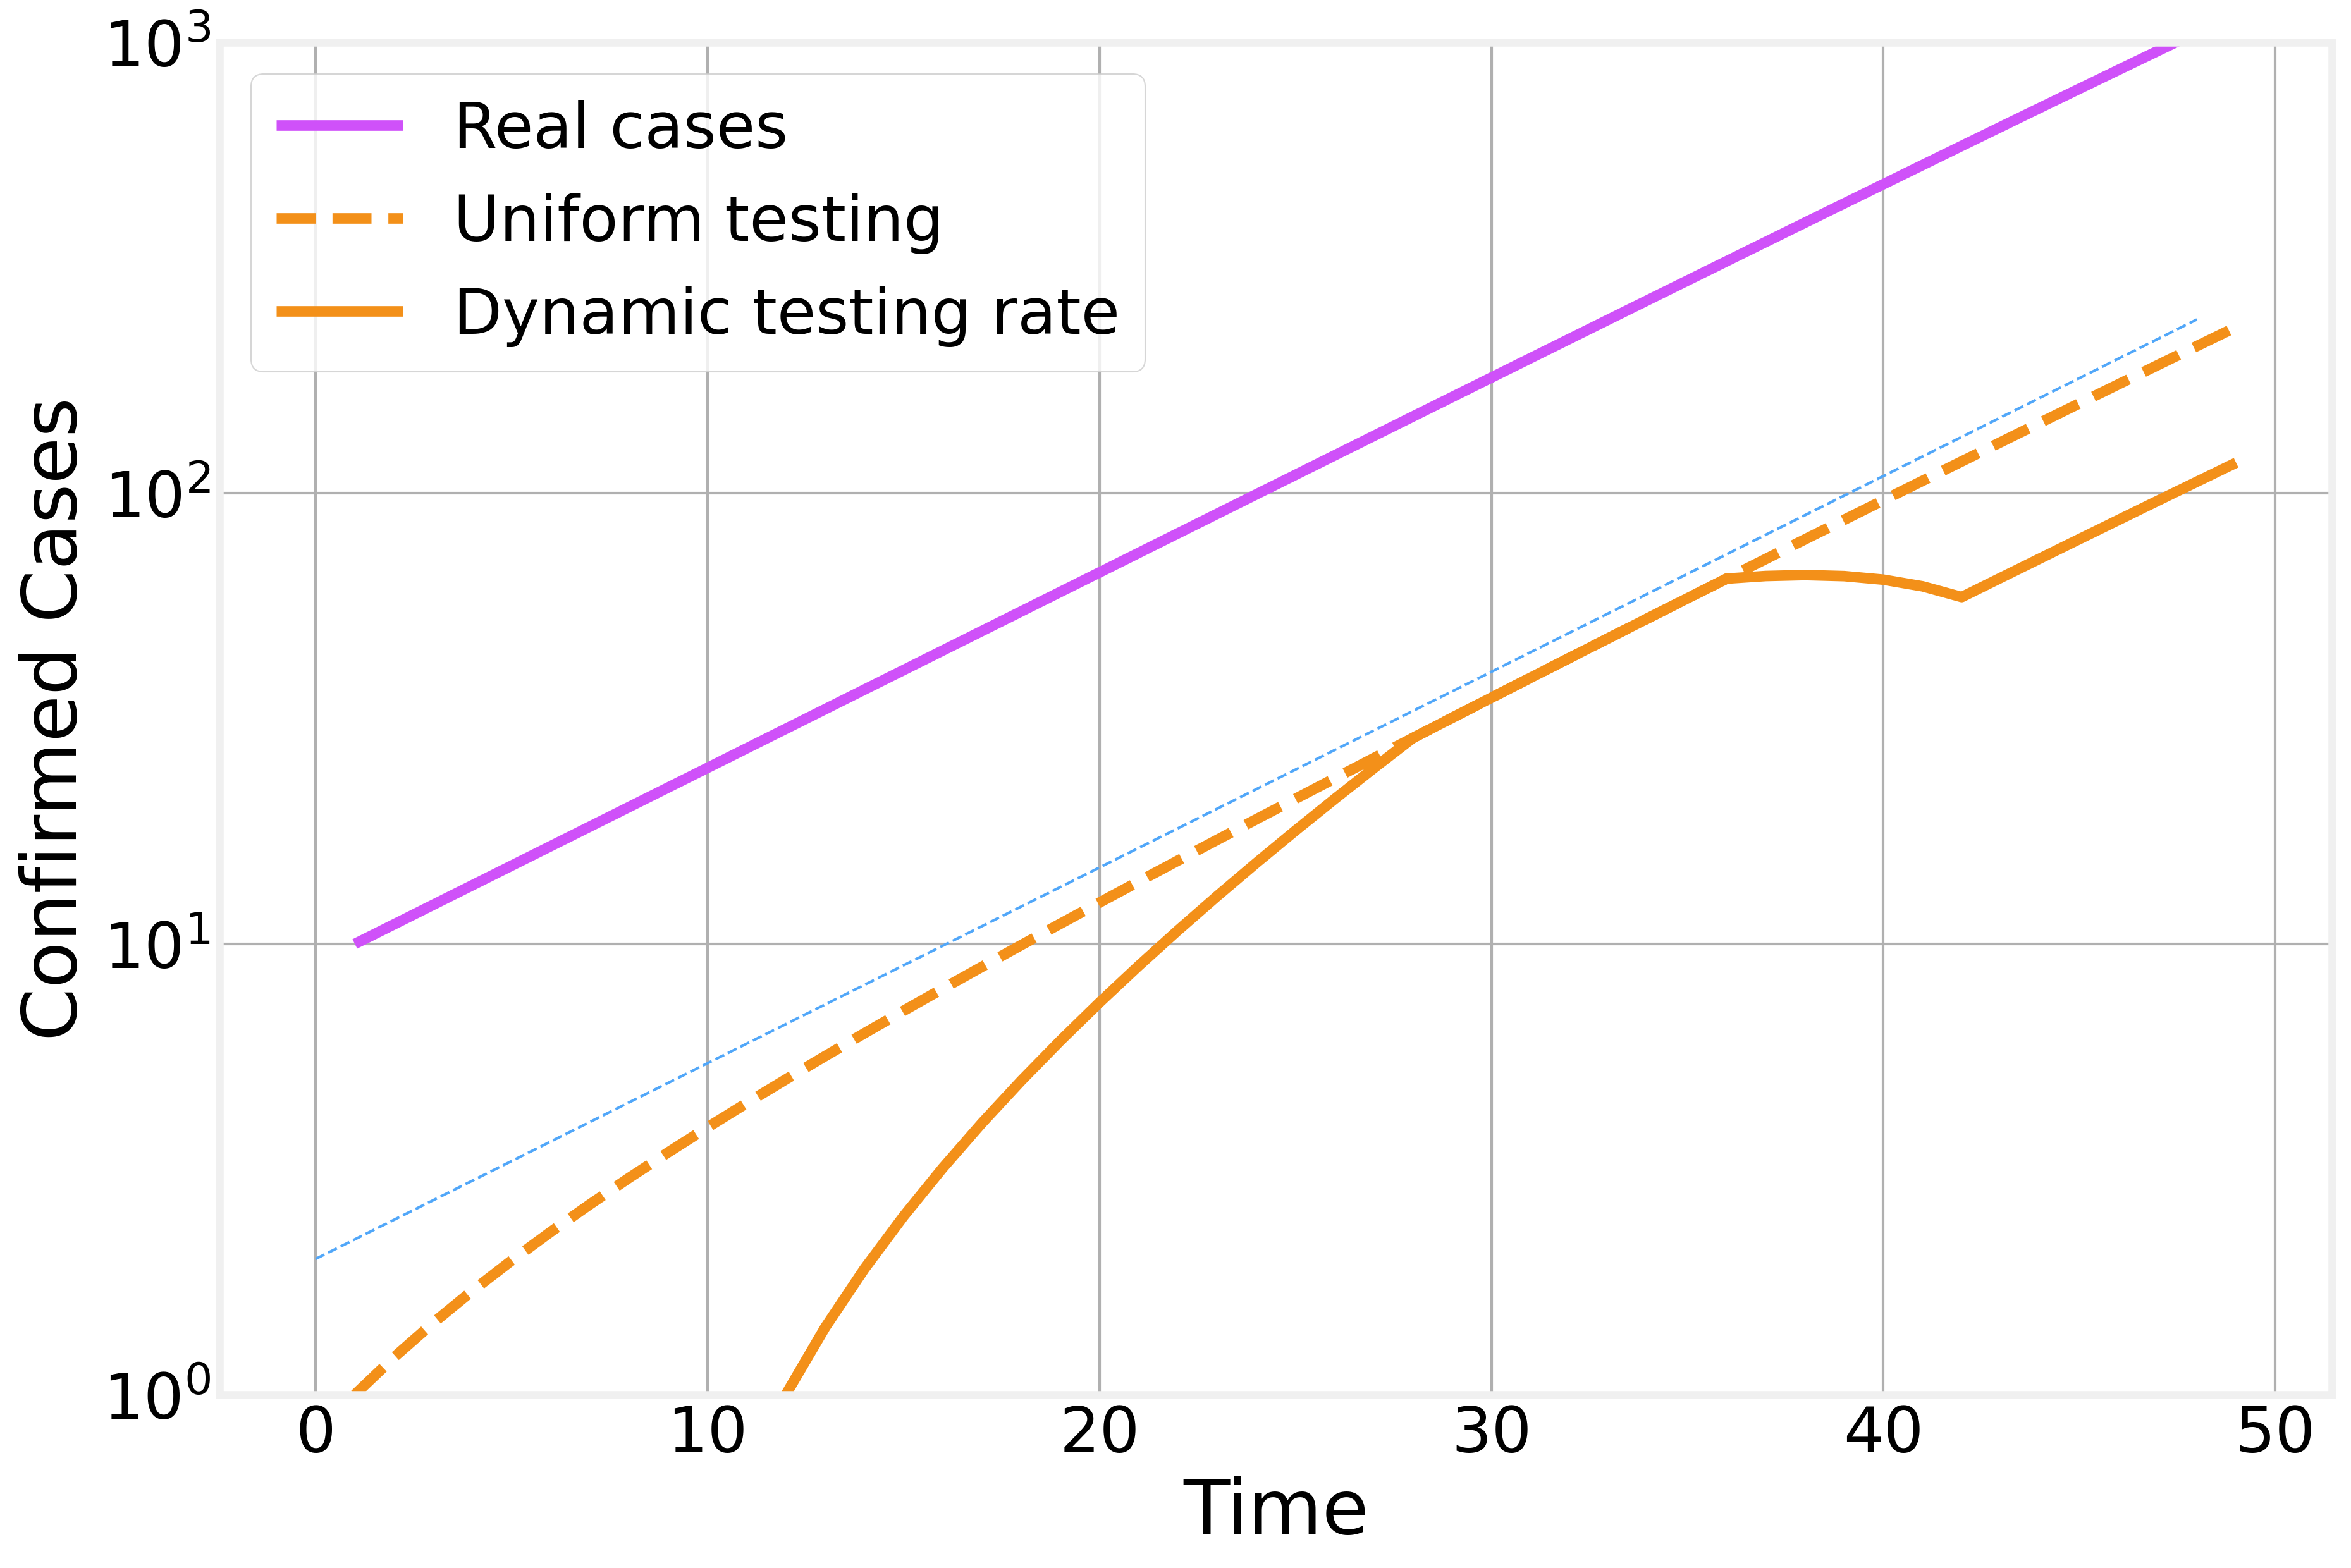

In [18]:
phi_t[35:42]=np.linspace(0.1, 0.05, 7) # Gradually reduce the number of tests in the 5th week
phi_t[42:] *= 0.5 # stay at 0.05 for the rest of the time

ax = SIR.I.iloc[:49].plot(label='Real cases', color=colors[1])
(phi*(N-SIR.S)).iloc[:49].plot(ax=ax, label='Uniform testing', color=colors[3], linestyle='--')
(phi_t*(N-SIR.S)).iloc[:49].plot(ax=ax, label='Dynamic testing rate', color=colors[3])

t = np.arange(0, 49, 1)
y = 2*np.exp((beta-mu)*t)
ax.plot(t, y, lw=1, linestyle='--')
ax.set_ylim(1, 1000)
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Confirmed Cases')
ax.set_yscale('log')

In practice, the testing rate is not fixed and changes over time due to supply availability, policy changes, etc. As a result, trying to fit exponential curves to the numbers you hear in the news is at best, misleading.

## Dynamical lags

Another issue that can easily complicate things is the fact that epidemic models work a bit like conveyer belts. Susceptible get fed on one end, become infectious and eventually Recovered come out the other end. 

We calculate the number of __new infections__ as a function of time by looking at the change in the number of susceptibles and compare with the total number of currently infectious people. As the two curves have a very different range of values, we we normalize each curve by dividing it by its respective maximum value.

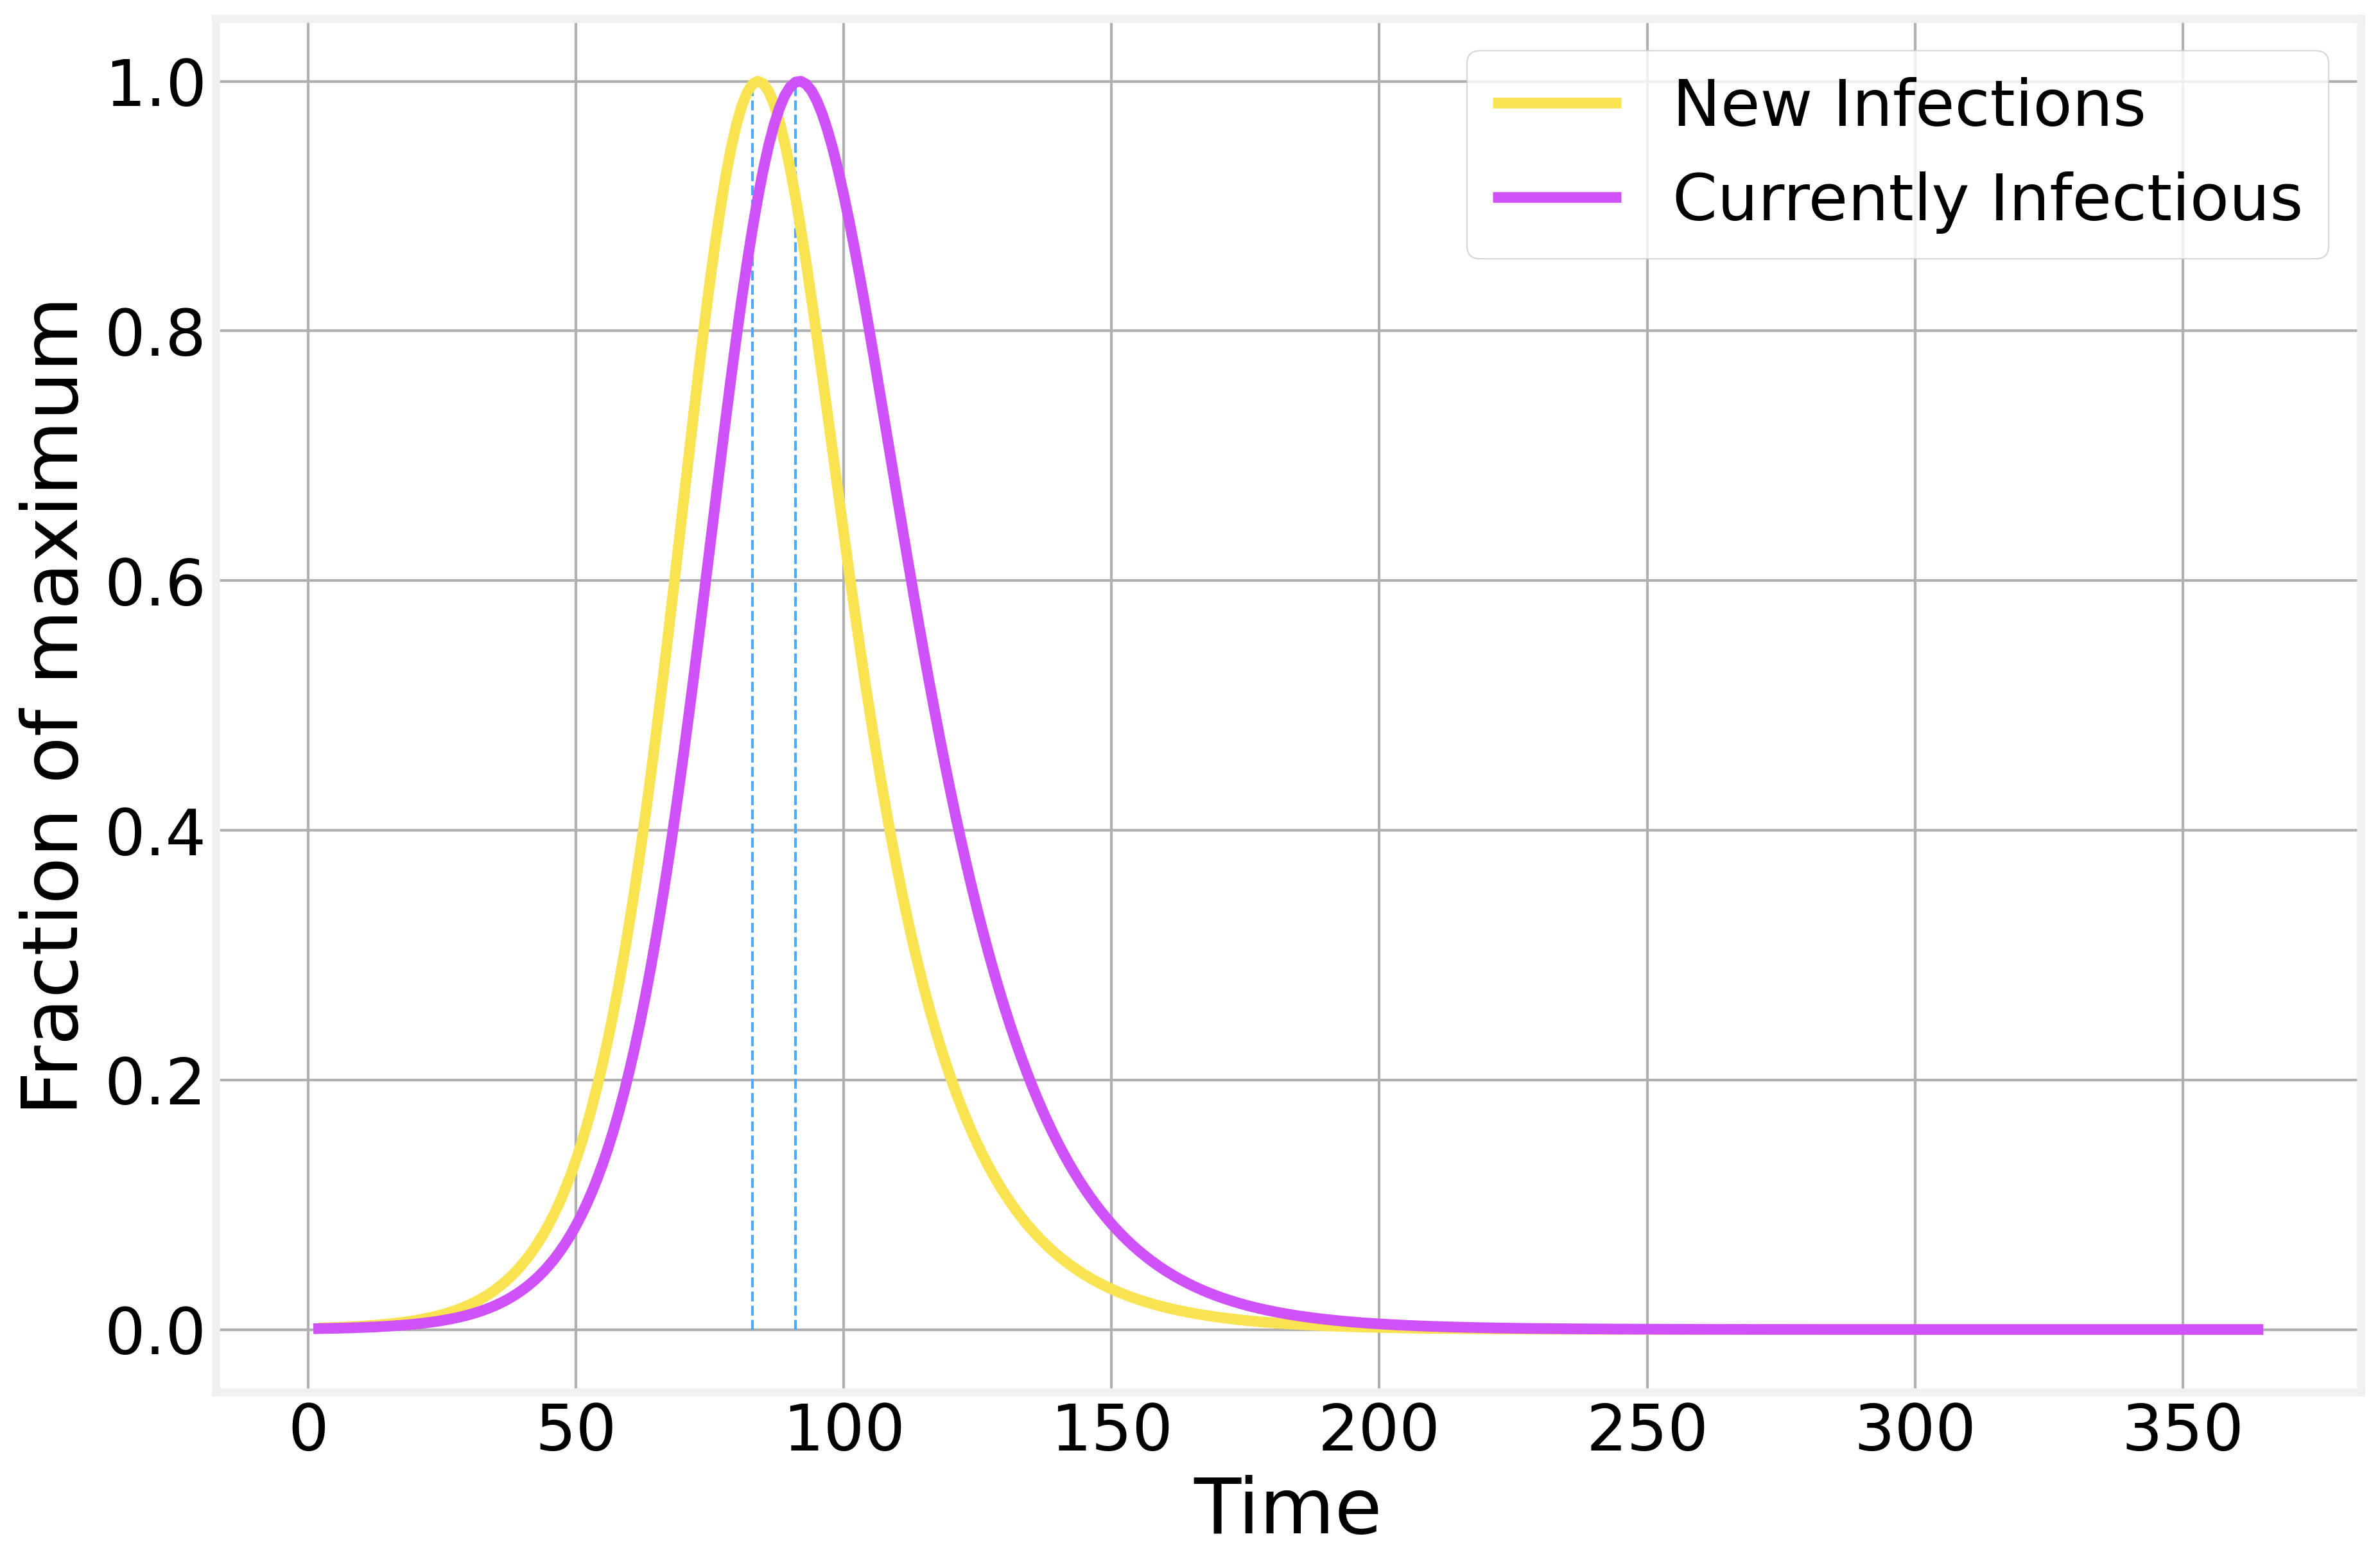

In [19]:
new_infections = (-SIR.S).diff(1)

new_infections_max = new_infections.argmax()
infectious_max = SIR.I.argmax()

ax=(new_infections/new_infections.max()).plot(label='New Infections', color=colors[4])
(SIR.I/SIR.I.max()).plot(ax=ax, label='Currently Infectious', color=colors[1])
ax.vlines(x=[new_infections_max, infectious_max], ymin=0, ymax=1, lw=1, linestyle='--')
ax.set_ylabel('Fraction of maximum')
ax.set_xlabel('Time')
ax.legend()

As we can see, there's a clear lag between the point as the rate of new infectious starts decreasing and the number of currently infectious individuals starts decreasing as well.

## Multiple populations

So far we have considered only a single population, but a usual, reality is much more complex. The fundamental assumption of compartmental models is that the population is well mixed: in effect, everyone is in contact with everyone. 

Naturally, this is not a very realistic assumption for anything larger than a small town. Let's see what happens if instead of a town we have several towns of the same size that get infected at different points in time.

As we already saw, the number of infectious individuals for a single population is, simply:

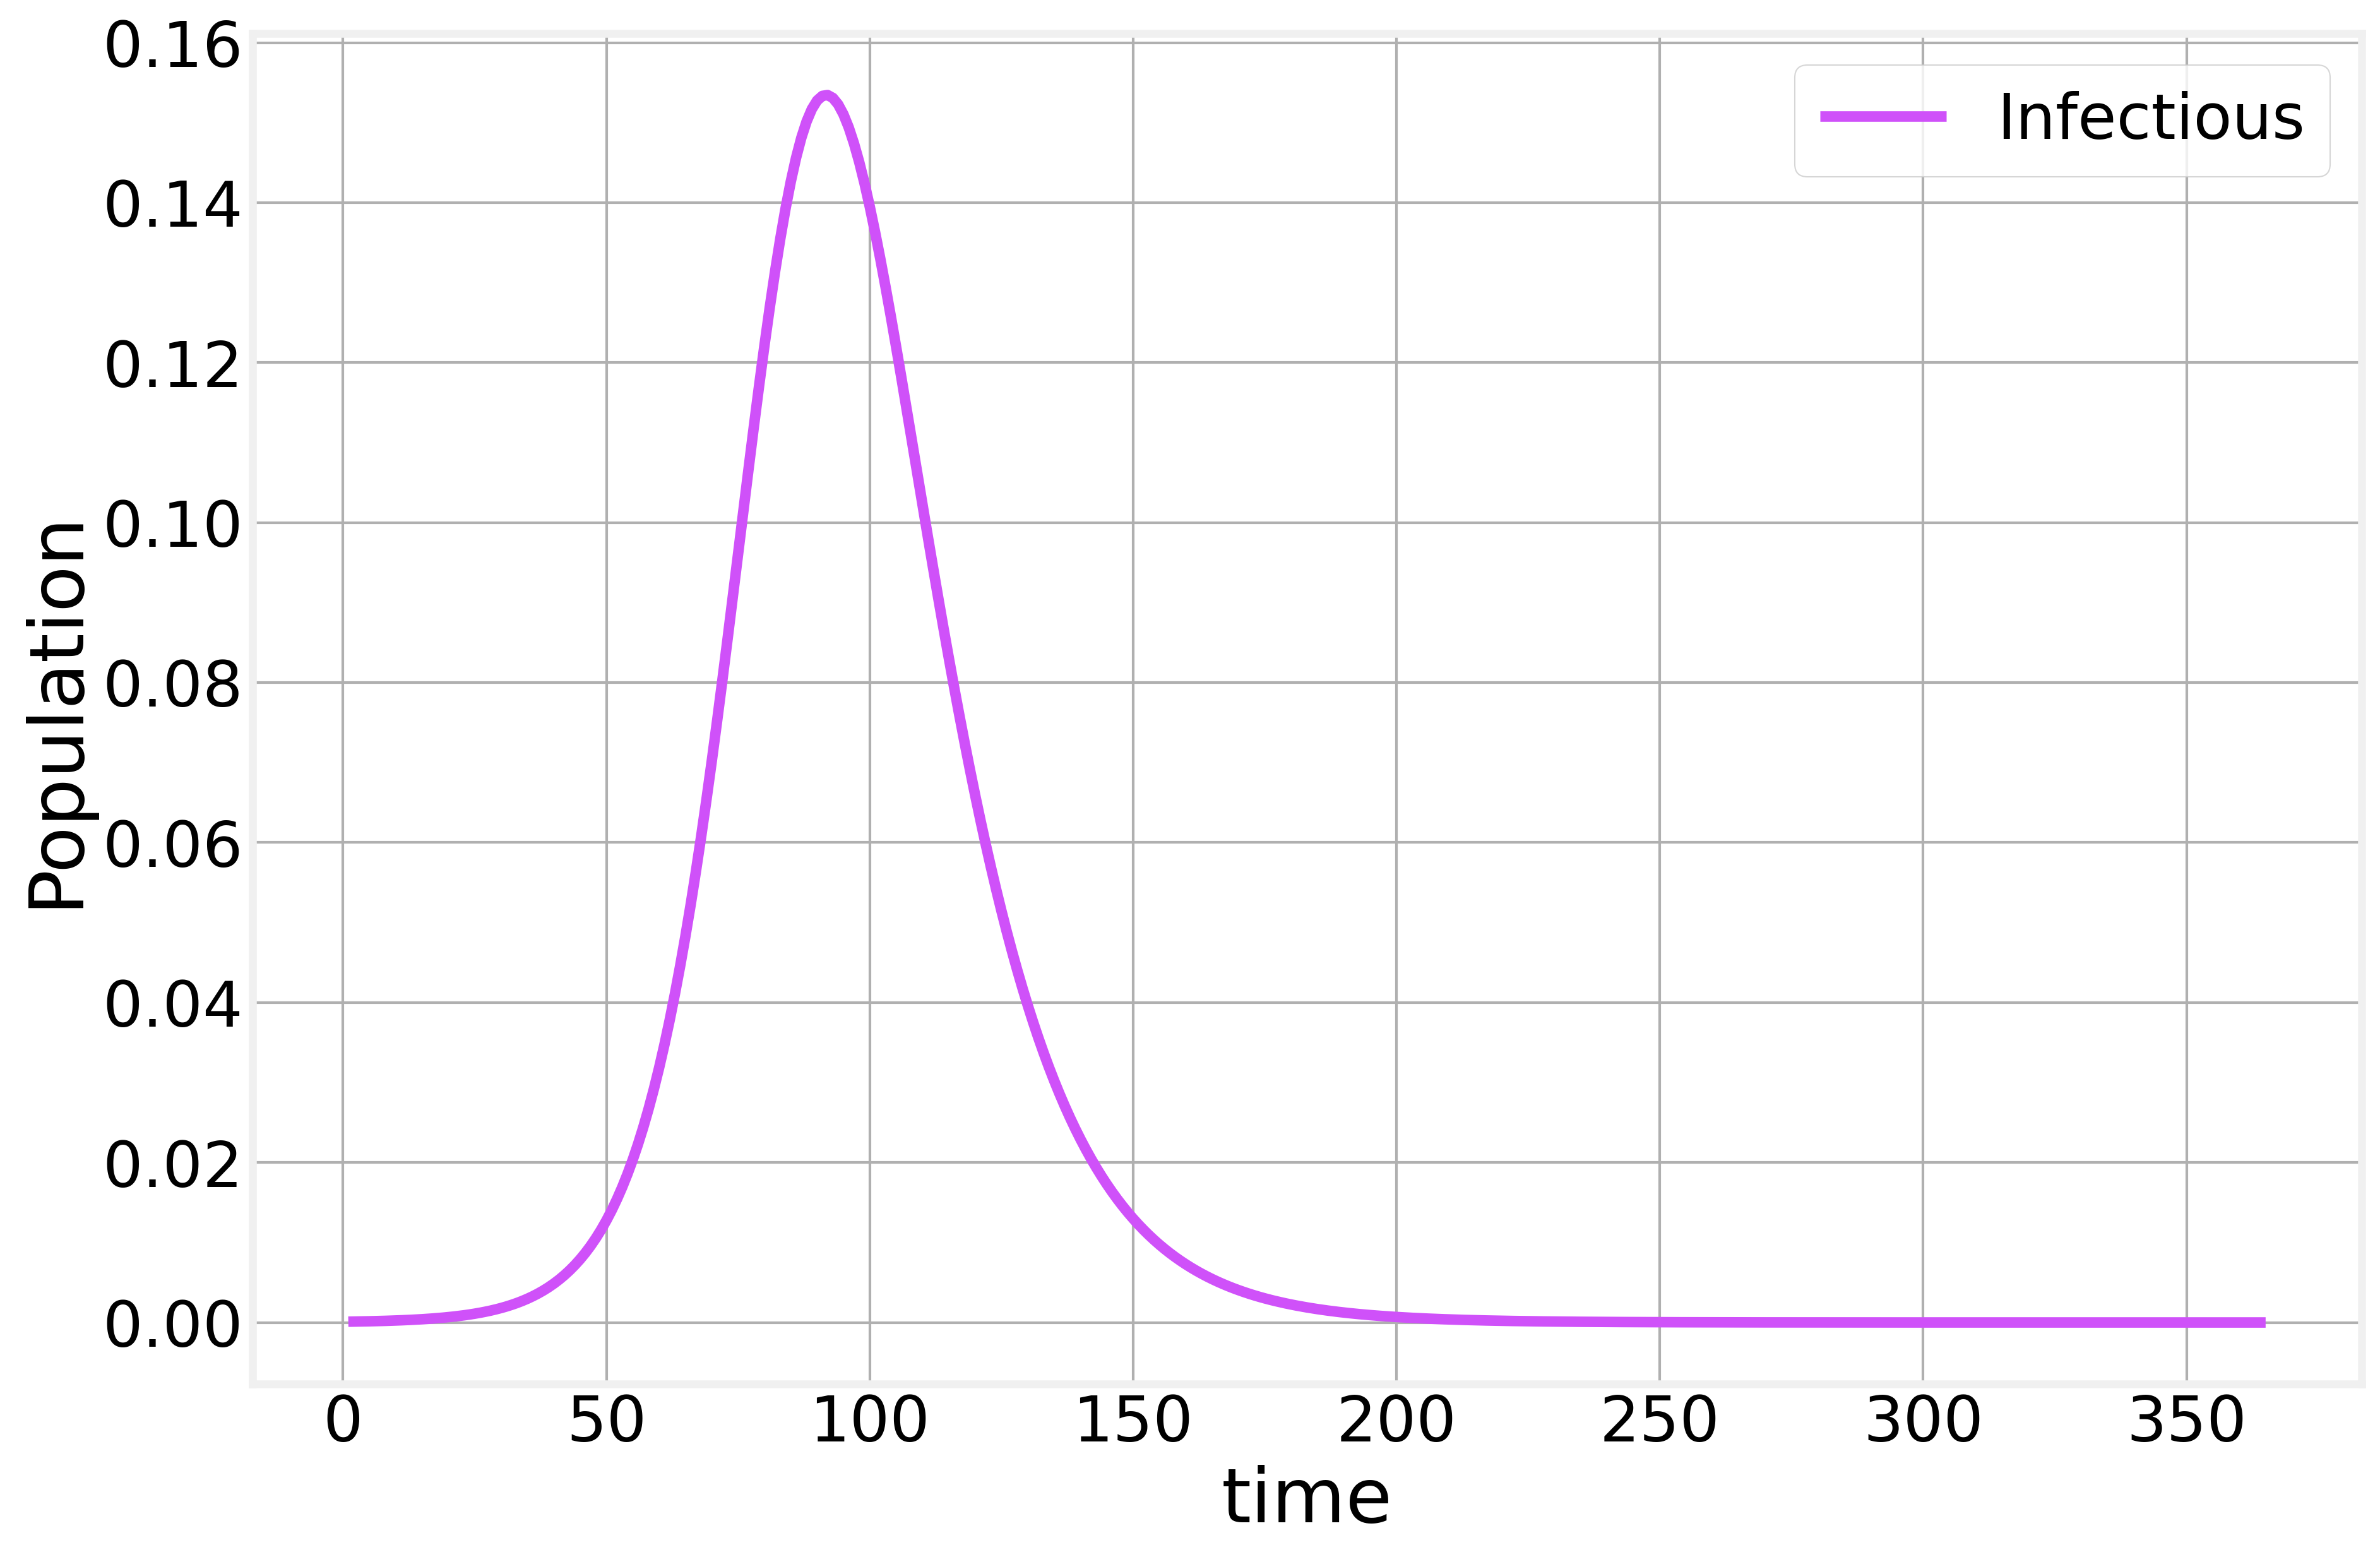

In [20]:
ax=(SIR.I/N).plot(label='Infectious', color=colors[1])
ax.set_xlabel('time')
ax.set_ylabel('Population')
ax.legend()

Countries, States, Regions and Cities aren't single homogenous population but rather a set of several tightly connected sub populations with the total numbers being the combination of the numbers in each area. If, after starting in 1 population, the infection spreads to a second and third ones after, say, 7 and 14 days, we have:

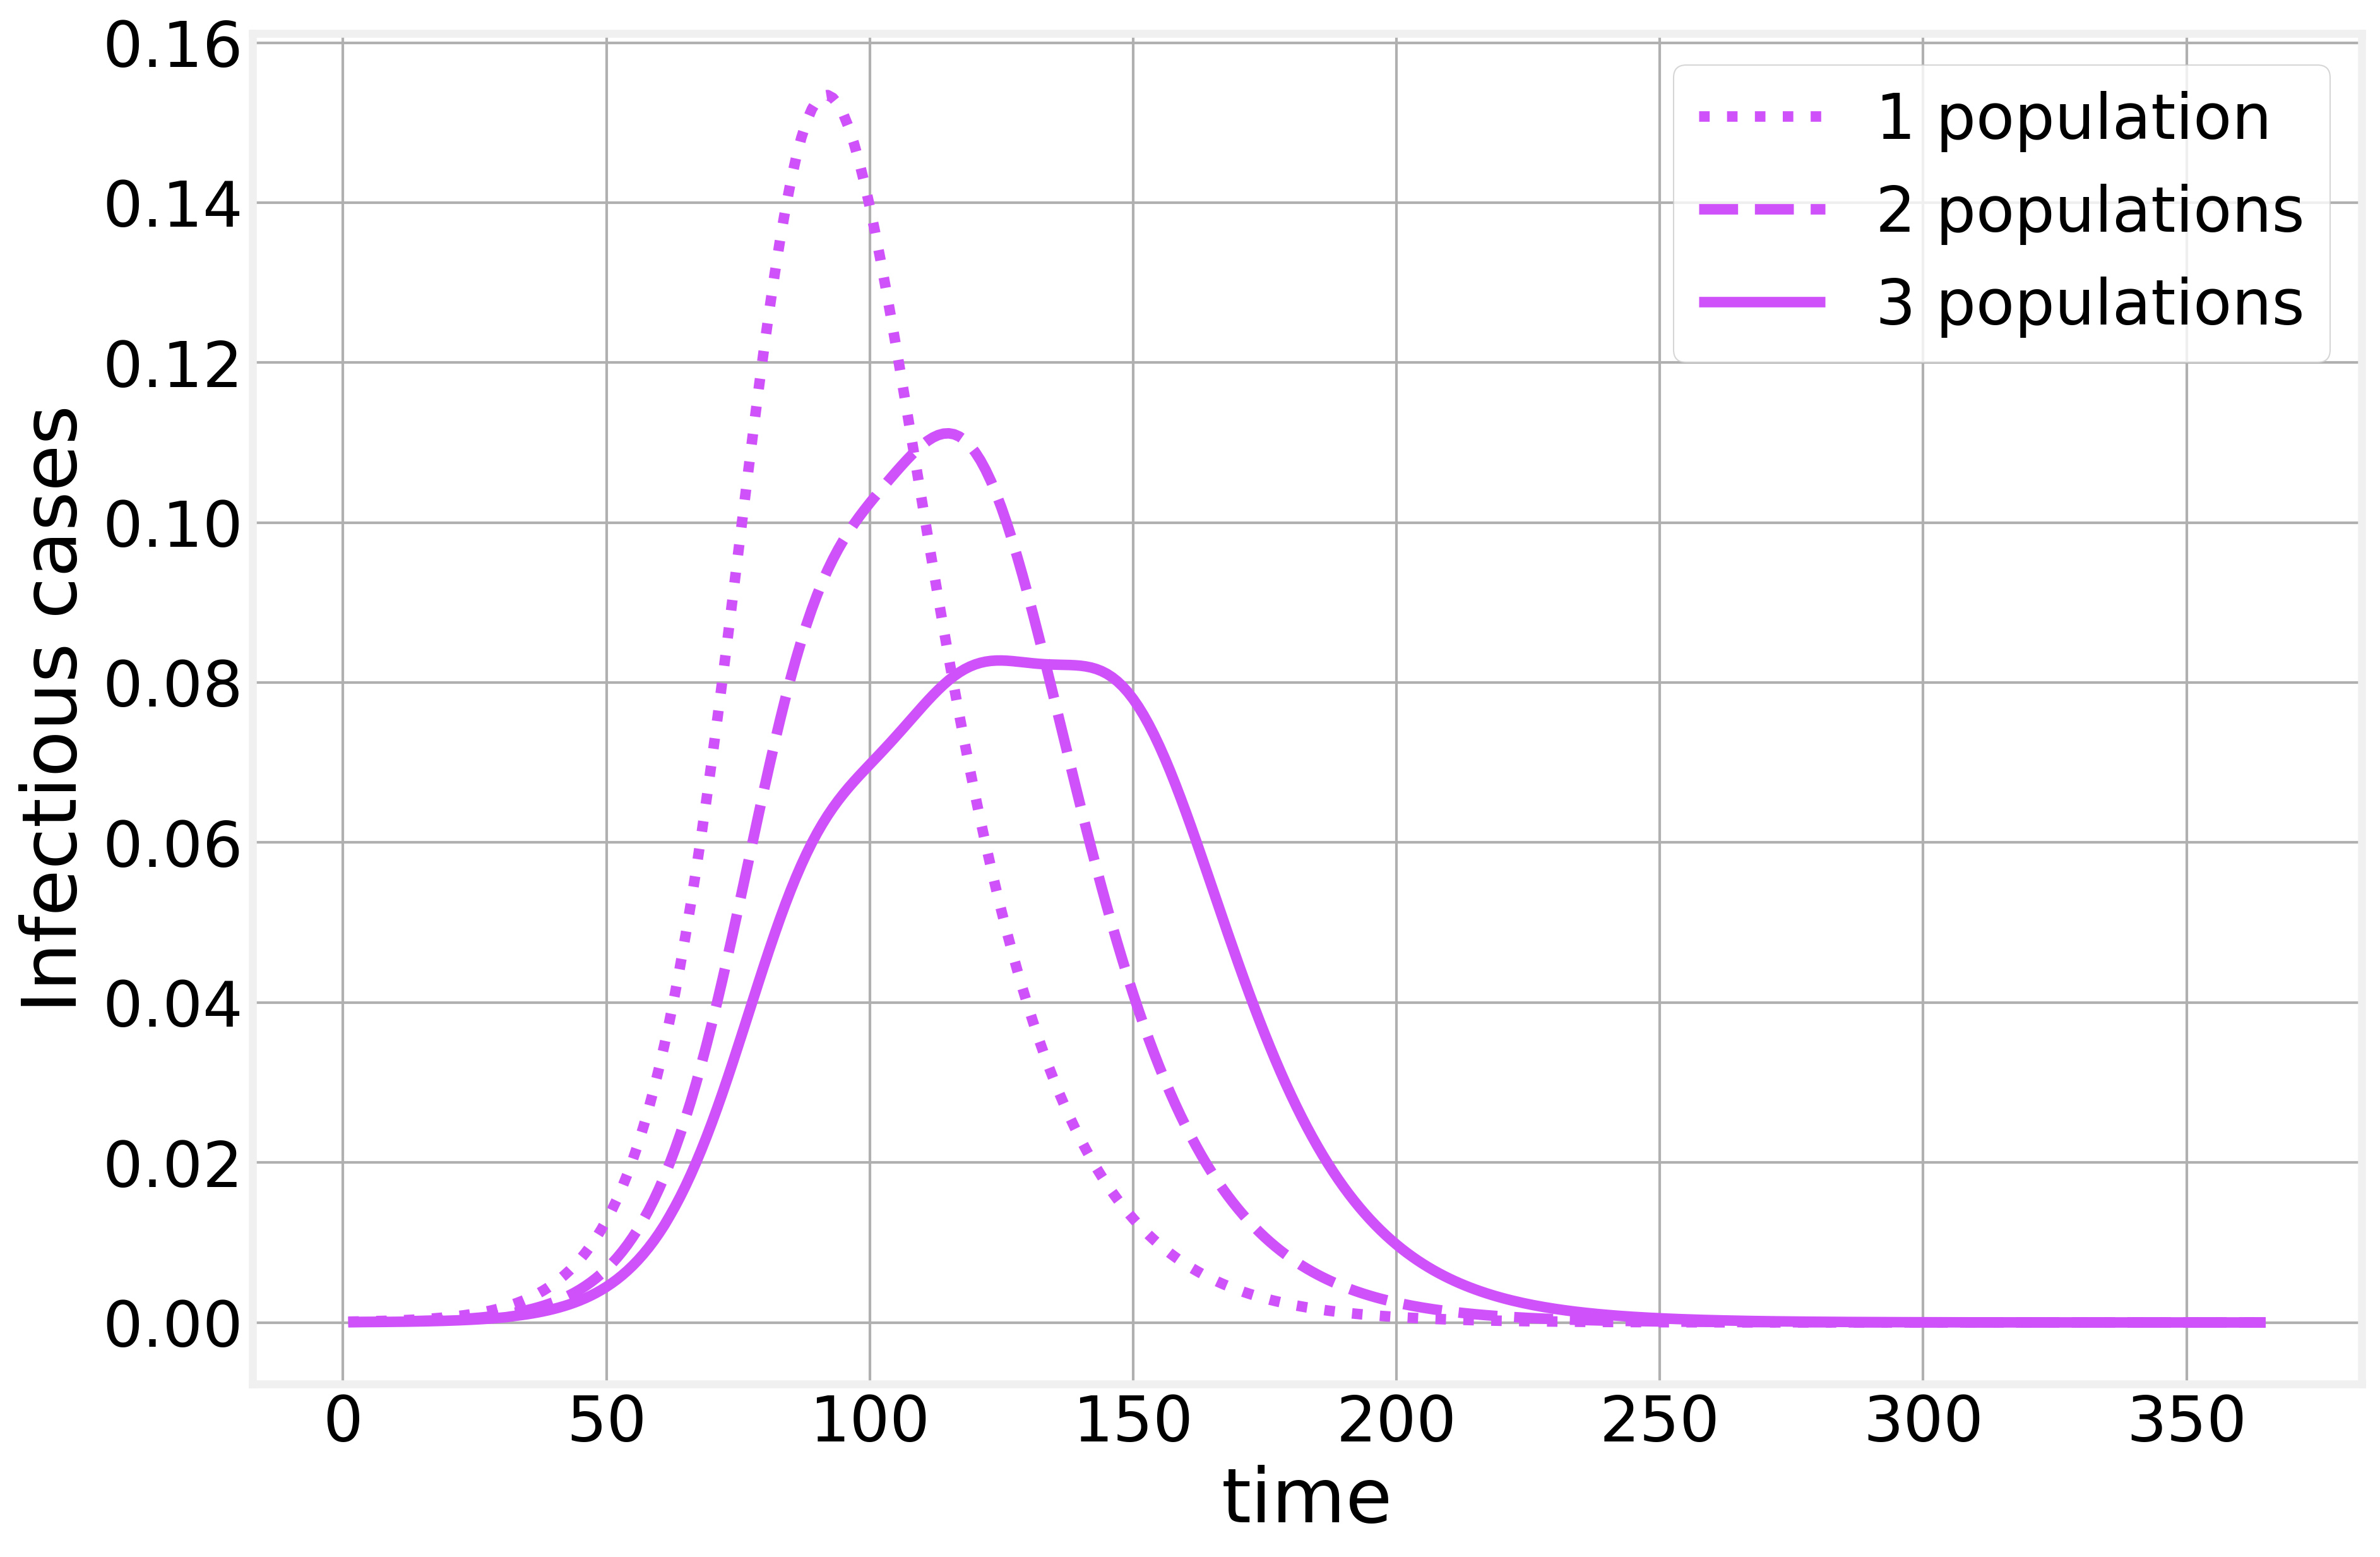

In [21]:
infections = (SIR.I).copy()

fig, ax = plt.subplots(1)
ax.plot(infections/N, color=colors[1], label='1 population', linestyle=':')
ax.plot((infections+infections.shift(31).fillna(0))/(2*N), color=colors[1], label='2 populations', linestyle='--')
ax.plot((infections+infections.shift(31).fillna(0)+infections.shift(61).fillna(0))/(3*N), color=colors[1], label='3 populations', linestyle='-')
ax.set_xlabel('time')
ax.set_ylabel('Infectious cases')
ax.legend()

Naturaly, the exact details of the connections each subpopulation will determine how impacted the shape of the curve will be,

<div style="width: 100%; overflow: hidden; float: center;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>